# 0.0 - PRBOLEMA DE NEGÓCIO
* Empresa de cartão de crédito trouxe um dataset dos últimos 6 meses contendo uma amostra de 30.000 titulares (demográficos e financeiros). 
* Os dados estão no nível conta (cada linha representa uma conta).
* As linhas são rotuladas de acordo com se no mês seguinte ao período de dados histórico de 6 meses um proprietário de conta ficou inadimplente. 
* O objetivo é desenvolver um modelo que preveja se uma conta ficará inadimplente no próximo mês. 

Biblioteca dos dados:
https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients

## 0.1 - Formato da solução

Arquivo CVS contendo a lista das contas que provavelmente ficarão inadimplentes no próximo mês: [list_prob_defaulted](list_prob_default_accounts/contas_inadimplentes.csv)

# 1.0 - IMPORTAÇÕES E COLETA DE DADOS

In [2]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import graphviz
import warnings
import inflection
import joblib

from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectPercentile
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import cross_val_score

In [3]:
# Ignora os avisos de warnings
warnings.filterwarnings( 'ignore' )

In [4]:
# Renderiza a plotagem automaticamente
%matplotlib inline

In [5]:
# Lê o dataset
df = pd.read_excel('dataset/data.xls')

# 2.0 - DESCRIÇÃO DOS DADOS

In [6]:
# Faz uma cópia do dataset
df1 = df.copy()

## 2.1 - Quantidade de dados

In [7]:
# Tamanho do dataset
# Imprimindo o número de linhas do dataframe df1
print('Número de Linhas: {}'.format(df1.shape[0]))

# Imprimindo o número de colunas do dataframe df1
print('Número de Colunas: {}'.format(df1.shape[1]))

Número de Linhas: 30000
Número de Colunas: 25


## 2.2 - Dicionário dos dados

* Informações repassadas pelo cliente:
  1. **ID**: identificador de conta única.
  2. **LIMIT_BAL**: valor do crédito fornecido, inclusive o crédito do consumidor individual e familiar (complementar).
  3. **SEX**: gênero (1 = masculino; 2 = feminino).
  4. **EDUCATION**: grau de instrução do titular (1 = pós graduação; 2 = universidade; 3 = ensino médio; 4 = outros).
  5. **MARRIAGE**: estado civil (1 = casado; 2 = solteiro; 3 = outros).
  6. **AGE**: idade em ano. 
  7. **PAY_1 a PAY_6**: registros de pagamentos passados. Pagamentos mensais passados, registrados de setembro a abril, respectivamente. 
      - A escala de medida do status de reembolso é a seguinte: -1 = pagamento pontual; 1 = atraso de um mês no pagamento; 2 = atraso de dois meses no pagamento, e assim por diante até 8 = atraso de oito meses no pagamento, 9 = atraso de nove ou mais meses no pagamento. 
      - "-2" significa que a conta começou o mês sem valor a ser pago e o crédito não foi usado.
      - "-1" significa que a conta usou um valor que foi totalmente pago.
      - "0" significa que o pagamento mínimo foi feito, mas o saldo total devedor não foi pago (isto é, uma parcela do saldo devedor foi transportada para o próximo mês)
  8. **BILL_ATM1 a BILL_ATM6**: representa o valor da fatura em setembro até abril. 
  9. **PAY_ATM1 a PAY_ATM6**: valor de pagamentos anteriores de setembro a abril. 
  10. **default payment next month**: Clientes que ficaram inadimplentes. Variável resposta.

In [8]:
# Exibe as cinco primeiras linhas
df1.head(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,798fc410-45c1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,8a8c8f3b-8eb4,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,85698822-43f5,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,0737c11b-be42,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,3b7f77cc-dbc0,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [9]:
# Nomes das colunas
df1.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

## 2.3 - Renomeando as Colunas

In [10]:
# Nomes originais das colunas antes da renomeação
cols_old = ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month']

# Função para converter os nomes das colunas em snake_case
snakecase = lambda x: inflection.underscore(x) 

# Nomes das colunas após a renomeação
cols_new = list(map(snakecase, cols_old))

# Renomeando as colunas do DataFrame usando os novos nomes
df1.columns = cols_new

In [11]:
df1.columns

Index(['id', 'limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_1',
       'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
       'default payment next month'],
      dtype='object')

## 2.4 - Tipo de Dados

In [12]:
# Tipos de dados
df1.dtypes

id                            object
limit_bal                      int64
sex                            int64
education                      int64
marriage                       int64
age                            int64
pay_1                         object
pay_2                          int64
pay_3                          int64
pay_4                          int64
pay_5                          int64
pay_6                          int64
bill_amt1                      int64
bill_amt2                      int64
bill_amt3                      int64
bill_amt4                      int64
bill_amt5                      int64
bill_amt6                      int64
pay_amt1                       int64
pay_amt2                       int64
pay_amt3                       int64
pay_amt4                       int64
pay_amt5                       int64
pay_amt6                       int64
default payment next month     int64
dtype: object

**PARA ETAPA DE LIMPEZA DE DADOS**
* INCONSISTÊNCIA 'pay_1':
  1. O tipo de dados de 'pay_1' deveriam ser números inteiros, de acordo com o dicionário de dados.

**Solução**: 
  1. Verificar o porque de conter strings em 'pay_1'
  2. Transformar 'pay_1' em inteiros após o tratamento dos valores ausentes. 

## 2.5 - Verificando integridade dos dados, os valores ausentes e os duplicados

In [13]:
# CHECK NAs
df1.isna().sum()

id                            0
limit_bal                     0
sex                           0
education                     0
marriage                      0
age                           0
pay_1                         0
pay_2                         0
pay_3                         0
pay_4                         0
pay_5                         0
pay_6                         0
bill_amt1                     0
bill_amt2                     0
bill_amt3                     0
bill_amt4                     0
bill_amt5                     0
bill_amt6                     0
pay_amt1                      0
pay_amt2                      0
pay_amt3                      0
pay_amt4                      0
pay_amt5                      0
pay_amt6                      0
default payment next month    0
dtype: int64

In [14]:
# Selecinando a coluna ID e contando os valores exclusivos
df1['id'].nunique()

29687

In [15]:
# Armazenando as contagens de valores em uma variável
id_counts = df1['id'].value_counts()
id_counts.head()

id
89f8f447-fca8    2
7c9b7473-cc2f    2
90330d02-82d9    2
75938fec-e5ec    2
2a793ecf-05c6    2
Name: count, dtype: int64

In [16]:
# Exibindo o número de entradas duplicadas agrupadas.
id_counts.value_counts()

count
1    29374
2      313
Name: count, dtype: int64

In [17]:
# Exibindo os registros com id = '89f8f447-fca8'
df_filtrado = df1[df1['id'] == '89f8f447-fca8']

# Exibindo o resultado
print(df_filtrado)

                 id  limit_bal  sex  education  marriage  age pay_1  pay_2  \
5033  89f8f447-fca8     320000    2          2         1   32     0      0   
5133  89f8f447-fca8          0    0          0         0    0     0      0   

      pay_3  pay_4  ...  bill_amt4  bill_amt5  bill_amt6  pay_amt1  pay_amt2  \
5033      0      0  ...     169371     172868     150827      8000      8000   
5133      0      0  ...          0          0          0         0         0   

      pay_amt3  pay_amt4  pay_amt5  pay_amt6  default payment next month  
5033      5500      6100      6000      5000                           0  
5133         0         0         0         0                           0  

[2 rows x 25 columns]


In [18]:
df1['pay_1'].value_counts()

pay_1
0                13402
-1                5047
1                 3261
Not available     3021
-2                2476
2                 2378
3                  292
4                   63
5                   23
8                   17
6                   11
7                    9
Name: count, dtype: int64

**PARA ETAPA DE LIMPEZA DE DADOS**
* INCONSISTÊNCIA EM 'id':
  1. Cada ID duplicado parece ter uma linha de dados válidos e outra somente com zeros.

**Solução**: Iremos exlcuir as linhas só de zeros. Elas podem ter surgido devido a uma condição de associação errada na consulta SQL que gerou os dados. E não faz sentido para o problema de negócio.

**PARA ETAPA DE LIMPEZA DE DADOS**
* INCONSISTÊNCIAS EM 'pay_1':
    1. Observamos que há dois valores não documentados, que são o 0 e -2. O que eles significam?
    2. Há uma string "Not available" presente na coluna, simbolizando dados ausentes.

**Solução**: Por enquanto, removeremos as linhas do dataset nas quais a característica tem um valor ausente. E perguntaremos ao "dono" do problema de negócio o que significam os valores 0 e -2. 

## 2.6 - Estatística descritiva dos dados

In [19]:
# Selecting numerical attributes (int64, float64, and int32) from the dataframe df1
num_attributes = df1.select_dtypes(include=['int64', 'float64', 'int32'])

# Selecting categorical attributes (excluding int64, float64, datetime64[ns], and int32) from the dataframe df1
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]', 'int32'])

In [20]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,limit_bal,0.0,1000000.0,1000000.0,165760.989333,140000.0,130156.421104,0.990467,0.536377
1,sex,0.0,2.0,2.0,1.586500,2.0,0.513340,-0.583327,-1.121935
2,education,0.0,6.0,6.0,1.833333,2.0,0.807685,0.836524,1.927734
3,marriage,0.0,3.0,3.0,1.535900,2.0,0.542689,-0.174510,-0.939403
4,age,0.0,79.0,79.0,35.108800,34.0,9.851428,0.216278,1.097650
5,pay_2,-2.0,8.0,10.0,-0.132867,0.0,1.191195,0.792986,1.622632
6,pay_3,-2.0,8.0,10.0,-0.164333,0.0,1.191076,0.841657,2.142098
7,pay_4,-2.0,8.0,10.0,-0.219300,0.0,1.162328,0.994420,3.540420
8,pay_5,-2.0,8.0,10.0,-0.263900,0.0,1.127500,1.001718,4.021999
9,pay_6,-2.0,8.0,10.0,-0.288033,0.0,1.144961,0.940800,3.444397


In [21]:
# Apply the lambda function to count the number of unique values in each categorical attribute
cat_attributes.apply(lambda x: x.unique().shape[0])

id       29687
pay_1       12
dtype: int64

**OBSERVAÇÕES**:
   1. Os dados parecem condizentes com os que nos foi passado no dicionário de dados.
   2. Exceto pelos valores mínimos em 'mariage', 'education'. Pode ser que os valores em 0 sejam de linhas duplicadas e/ou com valores ausentes não tratados. A limpeza dos dados vamos reanalisar a estatística descritiva.

# 3.0 - LIMPEZA E TRATAMENTO DOS DADOS

In [22]:
df2 = df1.copy()

## 3.1 - Tratando a coluna 'id' - valores duplicados

In [23]:
# Removendo as duplicatas onde há linhas com apenas zeros nas colunas de características
df2 = df2.loc[~df2.iloc[:, 1:].eq(0).all(axis=1)].copy()

# Removendo os duplicados, mantendo apenas a primeira ocorrência válida de cada ID
df2 = df2.drop_duplicates(subset=['id'], keep='first')

# Verificando o resultado final
df2.shape
df2['id'].nunique()

29685

In [24]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29685 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   id                          29685 non-null  object
 1   limit_bal                   29685 non-null  int64 
 2   sex                         29685 non-null  int64 
 3   education                   29685 non-null  int64 
 4   marriage                    29685 non-null  int64 
 5   age                         29685 non-null  int64 
 6   pay_1                       29685 non-null  object
 7   pay_2                       29685 non-null  int64 
 8   pay_3                       29685 non-null  int64 
 9   pay_4                       29685 non-null  int64 
 10  pay_5                       29685 non-null  int64 
 11  pay_6                       29685 non-null  int64 
 12  bill_amt1                   29685 non-null  int64 
 13  bill_amt2                   29685 non-null  int64 


## 3.2 - Tratando a coluna 'pay_1' - Valores ausentes

In [25]:
# 1. Substituir "Not available" por NaN
df2['pay_1'].replace('Not available', np.nan, inplace=True)

# 2. Calcular a moda da coluna pay_1
moda_pay_1 = df2['pay_1'].mode()[0]

# 3. Preencher os valores NaN pela moda
df2['pay_1'].fillna(moda_pay_1, inplace=True)

# 4. Converter a coluna pay_1 de object para int
df2['pay_1'] = df2['pay_1'].astype('int64')

# Verificando a estrutura do DataFrame após as alterações
df2[['pay_1', 'pay_2']].info()

# Exibindo a contagem dos valores únicos na coluna pay_1
print(df2['pay_1'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 29685 entries, 0 to 29999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   pay_1   29685 non-null  int64
 1   pay_2   29685 non-null  int64
dtypes: int64(2)
memory usage: 695.7 KB
pay_1
 0    16108
-1     5047
 1     3261
-2     2476
 2     2378
 3      292
 4       63
 5       23
 8       17
 6       11
 7        9
Name: count, dtype: int64


In [26]:
# df2['pay_1'].value_counts()

In [27]:
# # Substituindo o valor "Not available" por NaN e removendo os valores ausentes
# df2['pay_1'].replace('Not available', np.nan, inplace=True)

# # Removendo as linhas que possuem NaN na coluna pay_1
# df2.dropna(subset=['pay_1'], inplace=True)

# # Convertendo a coluna pay_1 de object para int
# df2['pay_1'] = df2['pay_1'].astype('int64')

# # Verificando a estrutura do DataFrame após as alterações
# df2[['pay_1', 'pay_2']].info()


**OBSERVAÇÕES**:
* Em conversas com o CEO, nos foi passado o seguinte:
    1. "-2" significa que a conta começou o mês sem valor a ser pago e o crédito não foi usado.
    2. "-1" significa que a conta usou um valor que foi totalmente pago.
    3. "0" significa que o pagamento mínimo foi feito, mas o saldo total devedor não foi pago (isto é, uma parcela do saldo devedor foi transportada para o próximo mês)

**Atualizei o dicionário dos dados**

## 3.3. - Reanálise das estatísticas descritivas

In [28]:
df2.describe()

,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default payment next month
count,29685.000000,29685.000000,29685.000000,29685.000000,29685.000000,29685.000000,29685.000000,29685.000000,29685.000000,29685.000000,...,29685.000000,29685.000000,29685.000000,29685.000000,2.968500e+04,29685.000000,29685.000000,29685.000000,29685.000000,29685.000000
mean,167519.948796,1.603335,1.852788,1.552198,35.481354,-0.015968,-0.134277,-0.166077,-0.221627,-0.266700,...,43245.439279,40307.628263,38888.682095,5672.886812,5.917545e+03,5229.295570,4826.770827,4805.203840,5219.023008,0.221054
std,129716.478534,0.489214,0.789465,0.521869,9.212199,1.067908,1.197440,1.197278,1.168278,1.133156,...,64276.899483,60787.204536,59588.111810,16616.452239,2.310628e+04,17650.360969,15607.256127,15311.798994,17798.365183,0.414964
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2329.000000,1760.000000,1257.000000,1000.000000,8.320000e+02,390.000000,296.000000,250.000000,115.000000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19040.000000,18106.000000,17067.000000,2100.000000,2.008000e+03,1800.000000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54515.000000,50244.000000,49252.000000,5007.000000,5.000000e+03,4508.000000,4015.000000,4041.000000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000,1.000000


* Em 'education' vemos graus de instrução não documentados, como: 0, 5 e 6
* **Solução**: Já que eles não são predominantes, vamos agrupa-los na categorias outros (4).

In [29]:
df2['education'].value_counts()

education
2    13884
1    10474
3     4867
5      275
4      122
6       49
0       14
Name: count, dtype: int64

In [30]:
df2['education'].replace(to_replace=[0,5,6], value=4, inplace=True)
df2['education'].value_counts()

education
2    13884
1    10474
3     4867
4      460
Name: count, dtype: int64

* Em 'marriage' vemos valores não documentados, como: 0
* **Solução**: Já que eles não são predominantes, vamos agrupa-los na categorias outros (3).

In [31]:
df2['marriage'].value_counts()

marriage
2    15810
1    13503
3      318
0       54
Name: count, dtype: int64

In [32]:
df2['marriage'].replace(to_replace=[0], value=3, inplace=True)
df2['marriage'].value_counts()

marriage
2    15810
1    13503
3      372
Name: count, dtype: int64

## 3.4 - Formulação de Hipóteses

**Hipótese 1**:
    Se a renda mensal do cliente aumenta, a probabilidade de inadimplência diminui.
* Racional: Clientes com maior renda têm mais capacidade de pagar suas faturas em dia.

**Hipótese 2**:
    Clientes com maior número de transações por mês têm uma menor taxa de inadimplência.
* Racional: Maior atividade pode indicar um melhor controle financeiro e uso frequente do crédito.

**Hipótese 3**:
    Clientes que utilizam mais de 70% do limite de crédito têm uma maior probabilidade de inadimplência.
* Racional: Uso excessivo do crédito pode indicar problemas financeiros e dificuldade em manter pagamentos.

**Hipótese 4**:
    Clientes que têm um histórico de pagamentos irregulares têm uma maior probabilidade de inadimplência.
* Racional: Histórico de pagamentos irregulares é um forte indicador de comportamento financeiro problemático.

**Hipótese 5**:
    A idade do cliente influencia a probabilidade de inadimplência, com um risco maior em faixas etárias específicas.
* Racional: Diferentes faixas etárias podem ter comportamentos financeiros distintos e capacidades variadas de pagamento.

**Hipótese 6**:
    Clientes que recebem promoções de juros ou ofertas especiais têm uma menor taxa de inadimplência.
* Racional: Promoções e ofertas podem incentivar o uso responsável do crédito e o pagamento em dia.

# 4.0 - ANÁLISE EXPLORATÓRIA DOS DADOS

1. Para explorar os dados, usaremos o histograma. 
2. Eles são uma boa maneira de visualziar dados que estejam em uma escala contínua, como valores monetários e faixas etárias.
3. Um histograma agrupa valores semelhantes em bins e exibe o número de pontos de dados existentes nesses bins como um gráfico de barras.

In [33]:
df3 = df2.copy()

## 4.1 - Análise Univariada

### 4.1.1 - Analise das colunas - Idade e Limite de Crédito

* Nenhuma das variáveis age e limit_bal segue uma distribuição normal. Ambas são assimétricas à direita, o que significa que a maioria dos valores está concentrada em faixas mais baixas e há uma diminuição gradual de frequência à medida que os valores aumentam, formando caudas à direita. Esses dados podem precisar de transformações ou ajustes se o modelo adota for de Regressão Logística (pois este o modelo assumi normalidade nas distribuições)

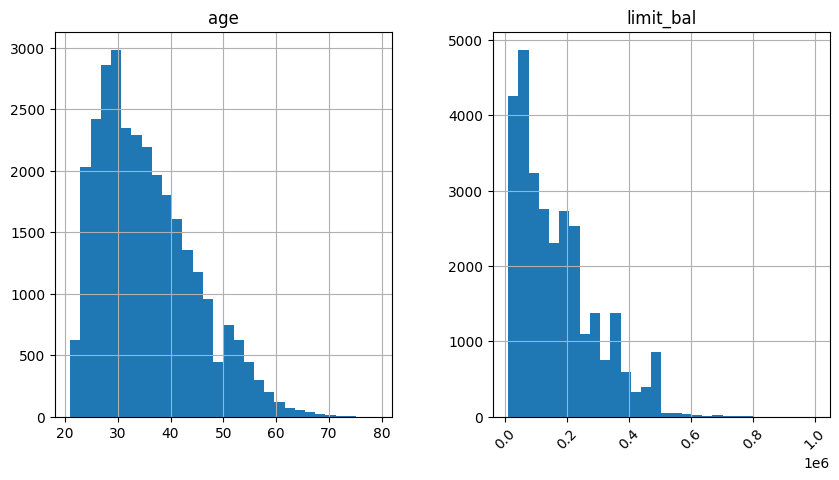

In [34]:
# Gerar o histograma para as colunas AGE e LIMIT_BAL
df3[['age', 'limit_bal']].hist(bins=30, figsize=(10, 5))

# Ajustar a rotação dos labels do eixo X para evitar sobreposição
plt.xticks(rotation=45)

# Mostrar o gráfico
plt.show()

In [35]:
# Fazendo análise descritiva para as colunas AGE e LIMIT_BAL
df3[['age', 'limit_bal']].describe()

,age,limit_bal
count,29685.000000,29685.000000
mean,35.481354,167519.948796
std,9.212199,129716.478534
min,21.000000,10000.000000
25%,28.000000,50000.000000
50%,34.000000,140000.000000
75%,41.000000,240000.000000
max,79.000000,1000000.000000


### 4.1.2 - Análise da coluna - Educação

- **Codificação Ordinal**: A codificação ordinal (1 a 4) pode não capturar adequadamente a natureza não linear da relação entre educação e inadimplência.
- **Codificação One-Hot (OHE)**: Utilizar OHE para transformar a variável educacional em variáveis binárias. Isso evita a suposição de ordem e pode melhorar a interpretação e o desempenho do modelo de Regressão Logística.

In [36]:
df3['education'].value_counts()

education
2    13884
1    10474
3     4867
4      460
Name: count, dtype: int64

Text(0.5, 0, 'Education level: ordinal encoding')

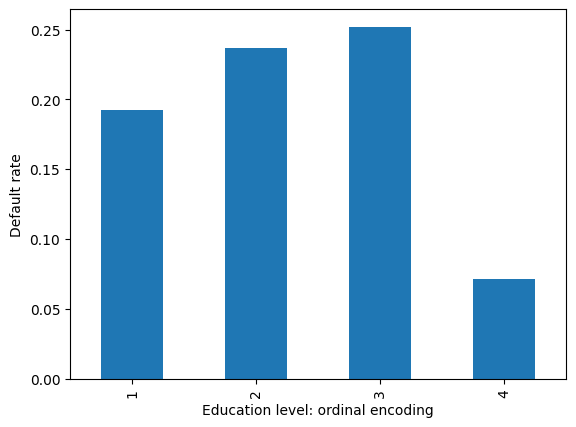

In [37]:
df3.groupby('education').agg({'default payment next month': 'mean'}).plot.bar(legend=False)
plt.ylabel('Default rate')
plt.xlabel('Education level: ordinal encoding')

In [38]:
## Implementando a Codificação One-Hot para a Característica Categórica - education
# Criando um dicionário de mapeamento para a coluna 'education'
cat_mapping = {
    1: "graduate school",
    2: "university",
    3: "high school",
    4: "others"
}

# Aplicando o mapeamento para criar uma nova coluna 'education_cat'
df3['education_cat'] = df3['education'].map(cat_mapping)

# Codificação one-hot da coluna 'education_cat'
edu_ohe = pd.get_dummies(df3['education_cat'], prefix='education')

# Concatenando o DataFrame de codificação one-hot com o DataFrame original
df3 = pd.concat([df3, edu_ohe], axis=1)

# Exibindo as primeiras linhas do DataFrame atualizado
df3[['education_cat', 'education', 'education_graduate school', 'education_high school', 'education_university', 'education_others']].head(10)


,education_cat,education,education_graduate school,education_high school,education_university,education_others
0,university,2,False,False,True,False
1,university,2,False,False,True,False
2,university,2,False,False,True,False
3,university,2,False,False,True,False
4,university,2,False,False,True,False
5,graduate school,1,True,False,False,False
6,graduate school,1,True,False,False,False
7,university,2,False,False,True,False
8,high school,3,False,True,False,False
9,high school,3,False,True,False,False


### 4.1.3 - Análise da coluna - Histórico Financeiro (PAY_X)

* Durante a exploração do histórico de pagamento, descobrimos que a maioria das contas estava em boa situação no mês passado, com poucos ou nenhum atraso. Contas com atrasos significativos eram menos comuns, o que é esperado, pois a maioria dos clientes tende a pagar suas dívidas rapidamente. No entanto, identificamos uma discrepância no número de contas com atraso de 2 meses em agosto, que excedeu o esperado. Isso sugere problemas com a precisão dos dados, possivelmente devido a erros na geração dos relatórios ou na coleta dos dados.

* Observou-se que as contas com atraso de 2 meses em agosto apresentavam valores irregulares para o status de pagamento de julho. Para que uma conta tenha um atraso de 2 meses, deveria haver um atraso de pelo menos um mês no mês anterior, mas nenhuma dessas contas indicava isso. O cliente relatou problemas na obtenção de dados atualizados, resultando em relatórios incorretos para contas com atraso de 1 mês.

* A correção parcial em setembro indicou que apenas os dados mais recentes são confiáveis e representativos para previsões futuras **("pay_1")**. A situação destaca a importância de uma verificação rigorosa da qualidade dos dados para garantir a precisão das análises e previsões. Recomenda-se uma revisão detalhada dos processos de coleta e geração de relatórios para evitar problemas semelhantes no futuro.

In [39]:
# Explorando as caracteristicas de histórico financeiro
pay_feats = ['pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']

df3[pay_feats].describe()

,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6
count,29685.000000,29685.000000,29685.000000,29685.000000,29685.000000,29685.000000
mean,-0.015968,-0.134277,-0.166077,-0.221627,-0.266700,-0.291090
std,1.067908,1.197440,1.197278,1.168278,1.133156,1.150653
min,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


In [40]:
df3[pay_feats[0]].value_counts().sort_index()

pay_1
-2     2476
-1     5047
 0    16108
 1     3261
 2     2378
 3      292
 4       63
 5       23
 6       11
 7        9
 8       17
Name: count, dtype: int64

In [41]:
pay_1_bins = np.array(range(-2, 10)) - 0.5

Text(0, 0.5, 'Number of accounts')

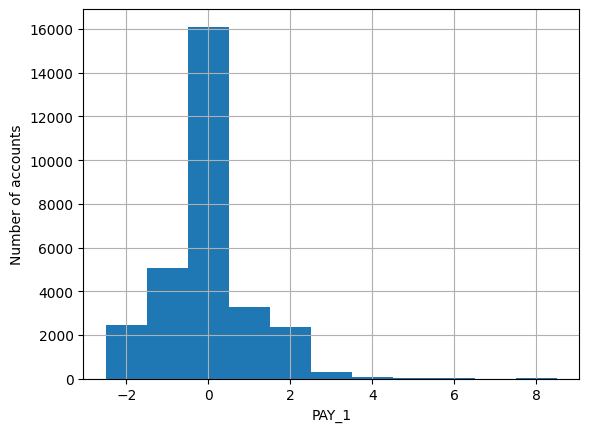

In [42]:
df3[pay_feats[0]].hist(bins=pay_1_bins)

# Ajustar a rotação dos labels do eixo X para evitar sobreposição
plt.xlabel('PAY_1')

# Mostrar o gráfico
plt.ylabel('Number of accounts')

array([[<Axes: title={'center': 'pay_1'}>,
        <Axes: title={'center': 'pay_2'}>,
        <Axes: title={'center': 'pay_3'}>],
       [<Axes: title={'center': 'pay_4'}>,
        <Axes: title={'center': 'pay_5'}>,
        <Axes: title={'center': 'pay_6'}>]], dtype=object)

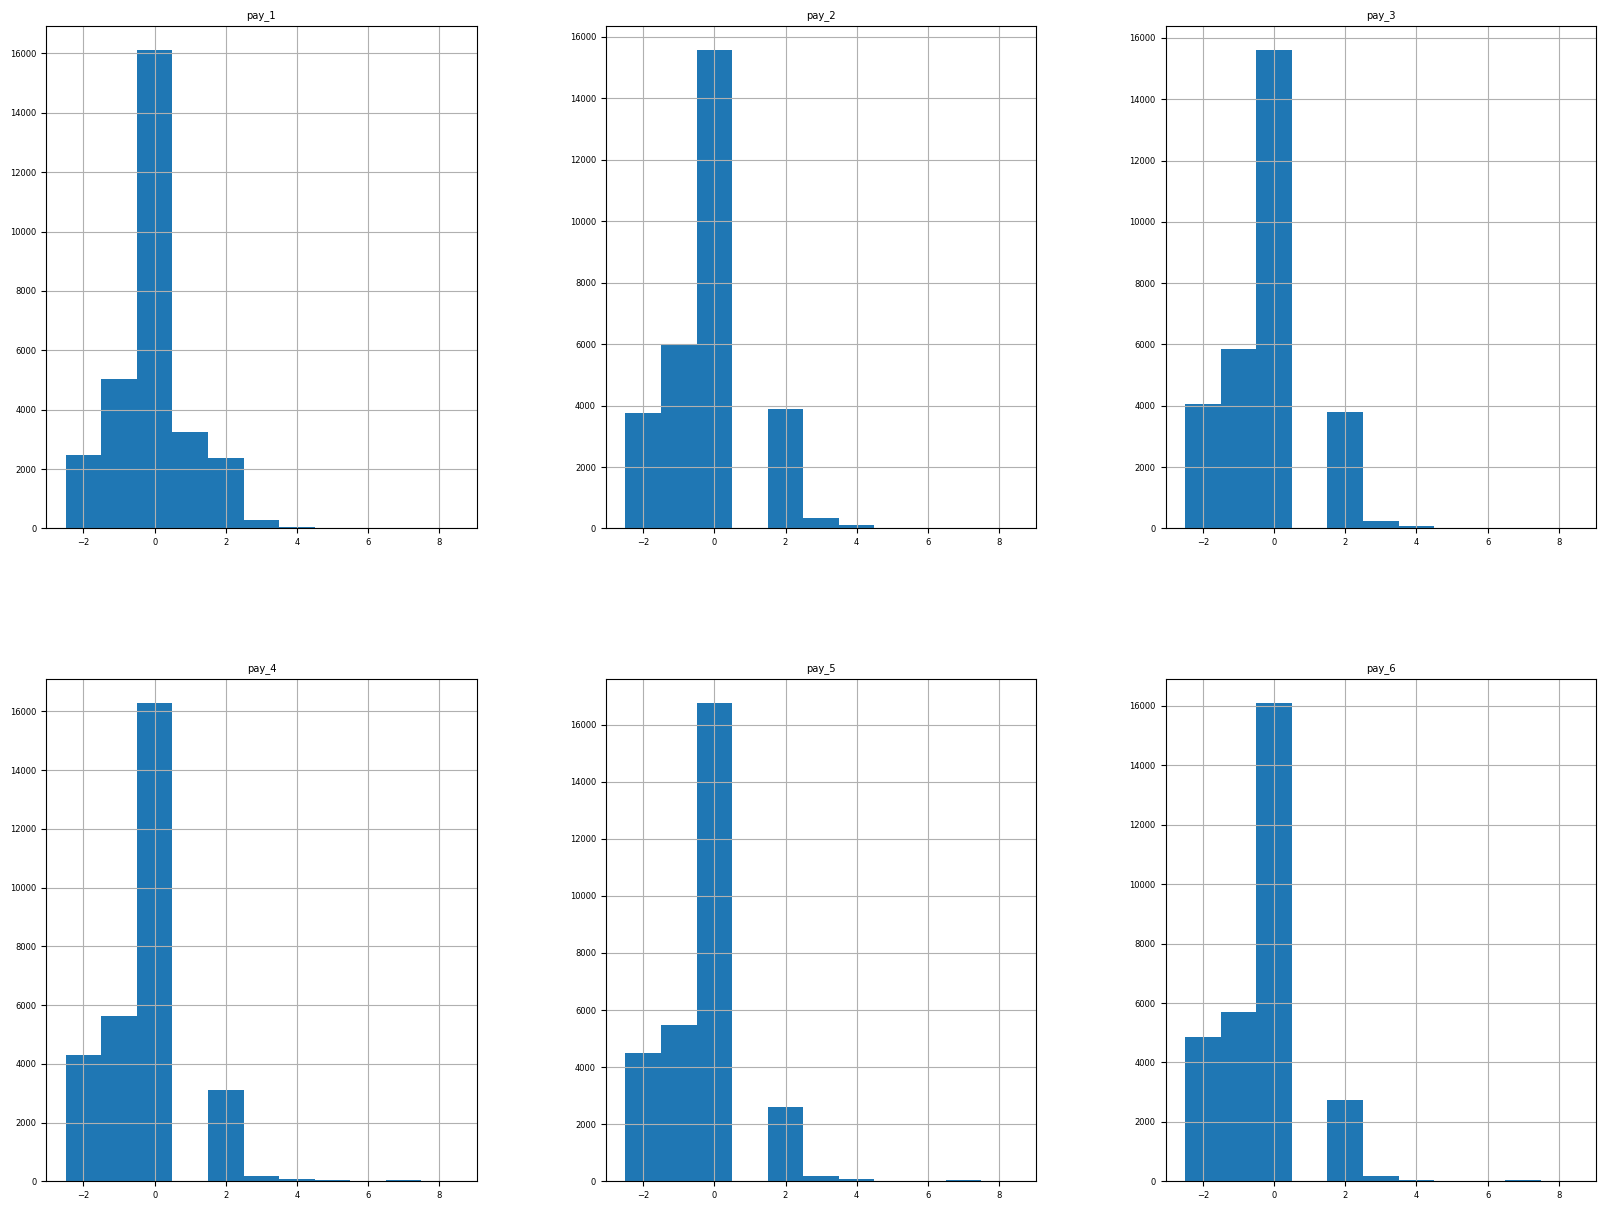

In [43]:
mpl.rcParams['font.size'] = 6
df3[pay_feats].hist(bins=pay_1_bins, layout=(2,3), figsize=(20,15))

In [44]:
df3.loc[df3['pay_2']== 2, ['pay_2', 'pay_3']].head()

,pay_2,pay_3
0,2,-1
1,2,0
13,2,2
15,2,0
50,2,2


### 4.1.4 - Análise das colunas - Valor ('bill_atm') e Pagamento da Fatura ('pay_atm')

Durante a análise das colunas de valores de fatura (bill_atm) e pagamentos (pay_atm), observou-se que:
* Faturas: A média mensal de cobrança está entre 40k e 50k, com uma alta variabilidade. Há a presença de valores negativos, possivelmente relacionados a pagamentos antecipados ou excessivos.
* Pagamentos: A média de pagamento é significativamente menor do que a média das faturas, sugerindo que muitos clientes não quitam o saldo total. A distribuição dos pagamentos está na faixa dos milhares e é consistente ao longo dos meses.

As visualizações e análises indicam uma variação considerável nas faturas e pagamentos, com a maioria das contas mostrando valores baixos e uma distribuição consistente ao longo do tempo.

In [45]:
# Explorando as caracteristicas financeiras restantes do dataset
bill_feats = ['bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6']

pay_amt_feats = ['pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']

In [46]:
df3[bill_feats].describe()

,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6
count,29685.000000,29685.000000,2.968500e+04,29685.000000,29685.000000,29685.000000
mean,51184.178103,49140.322553,4.699076e+04,43245.439279,40307.628263,38888.682095
std,73578.295929,71091.014997,6.930111e+04,64276.899483,60787.204536,59588.111810
min,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000
25%,3560.000000,2984.000000,2.663000e+03,2329.000000,1760.000000,1257.000000
50%,22381.000000,21197.000000,2.010700e+04,19040.000000,18106.000000,17067.000000
75%,67028.000000,63992.000000,6.016700e+04,54515.000000,50244.000000,49252.000000
max,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000


array([[<Axes: title={'center': 'bill_amt1'}>,
        <Axes: title={'center': 'bill_amt2'}>,
        <Axes: title={'center': 'bill_amt3'}>],
       [<Axes: title={'center': 'bill_amt4'}>,
        <Axes: title={'center': 'bill_amt5'}>,
        <Axes: title={'center': 'bill_amt6'}>]], dtype=object)

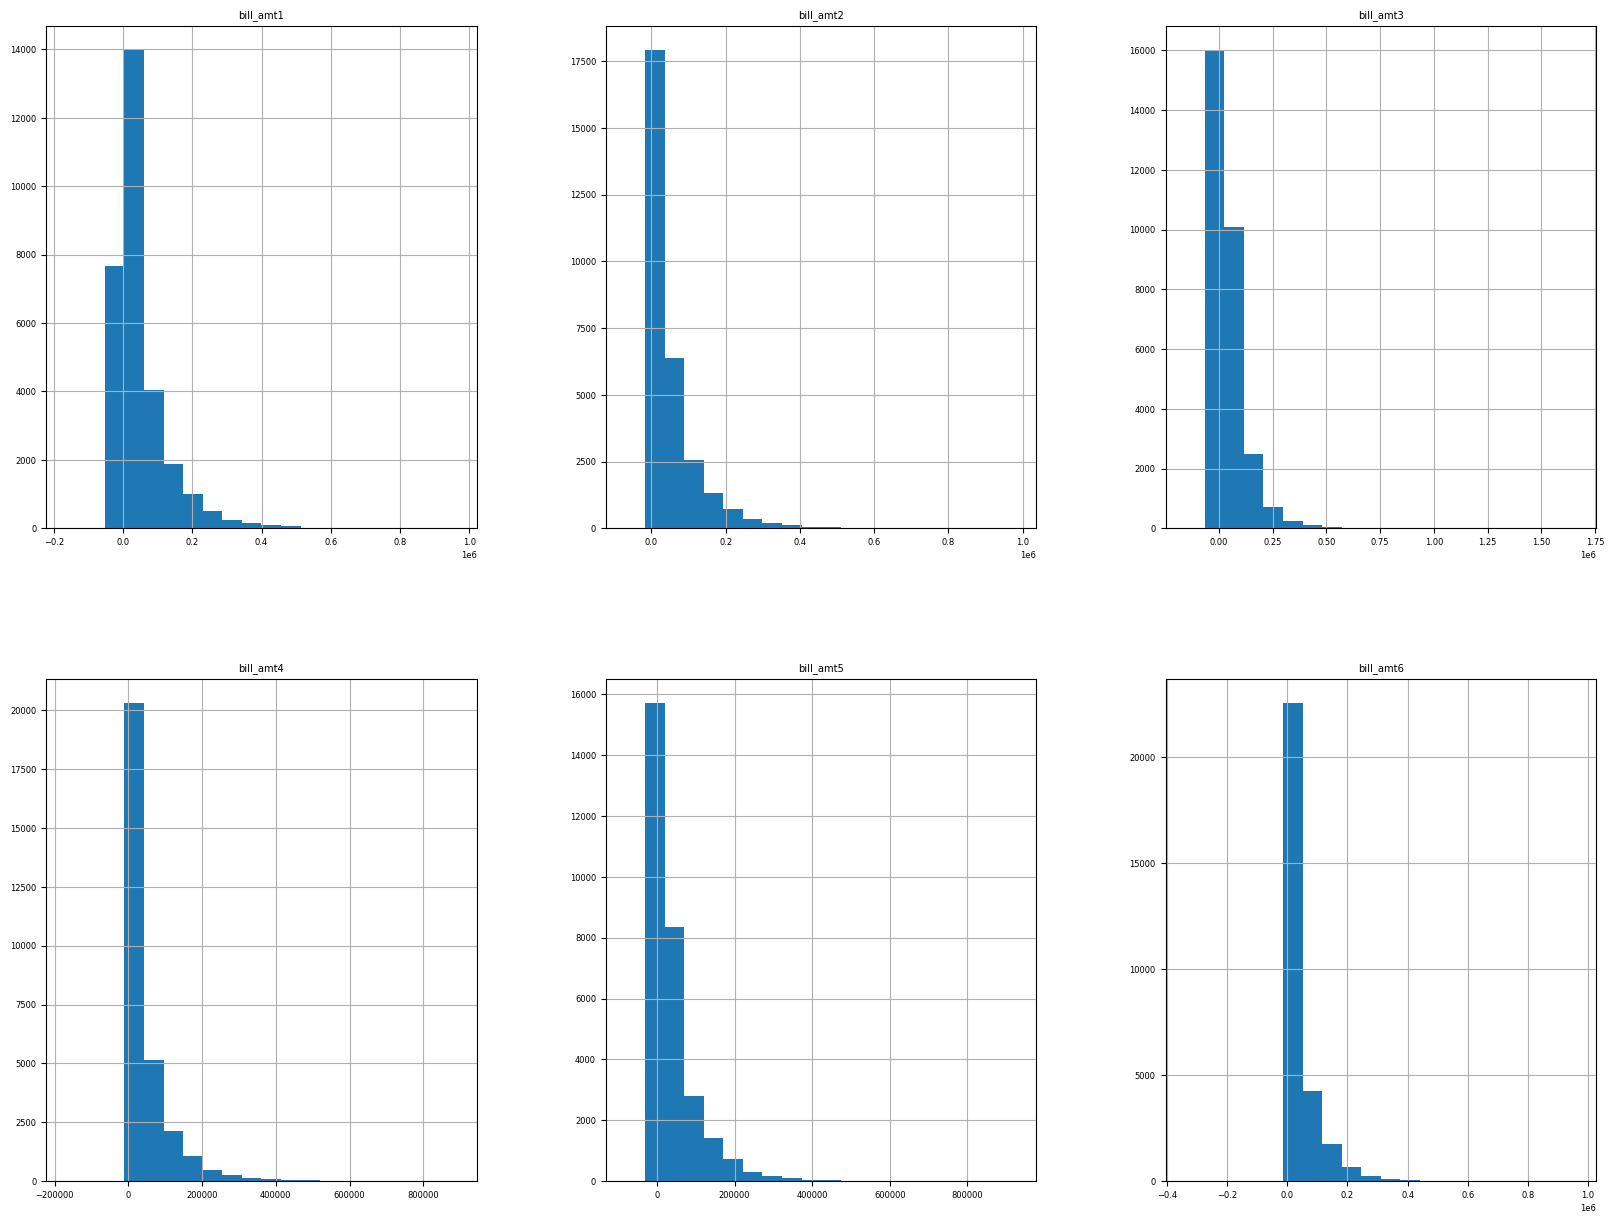

In [47]:
df3[bill_feats].hist(bins=20, layout=(2,3), figsize=(20,15))

In [48]:
df3[pay_amt_feats].describe()

,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6
count,29685.000000,2.968500e+04,29685.000000,29685.000000,29685.000000,29685.000000
mean,5672.886812,5.917545e+03,5229.295570,4826.770827,4805.203840,5219.023008
std,16616.452239,2.310628e+04,17650.360969,15607.256127,15311.798994,17798.365183
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,1000.000000,8.320000e+02,390.000000,296.000000,250.000000,115.000000
50%,2100.000000,2.008000e+03,1800.000000,1500.000000,1500.000000,1500.000000
75%,5007.000000,5.000000e+03,4508.000000,4015.000000,4041.000000,4000.000000
max,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000


array([[<Axes: title={'center': 'pay_amt1'}>,
        <Axes: title={'center': 'pay_amt2'}>,
        <Axes: title={'center': 'pay_amt3'}>],
       [<Axes: title={'center': 'pay_amt4'}>,
        <Axes: title={'center': 'pay_amt5'}>,
        <Axes: title={'center': 'pay_amt6'}>]], dtype=object)

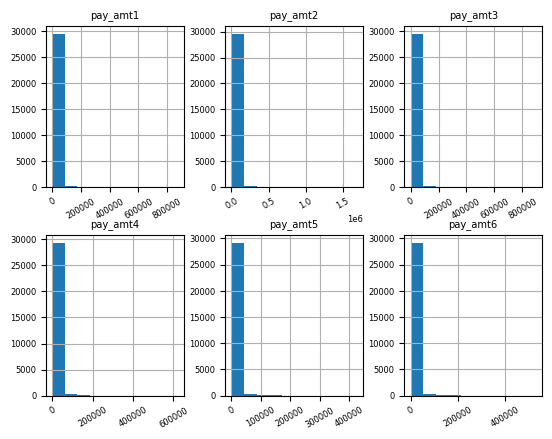

In [49]:
df3[pay_amt_feats].hist(bins=10, layout=(2,3), xrot=30)

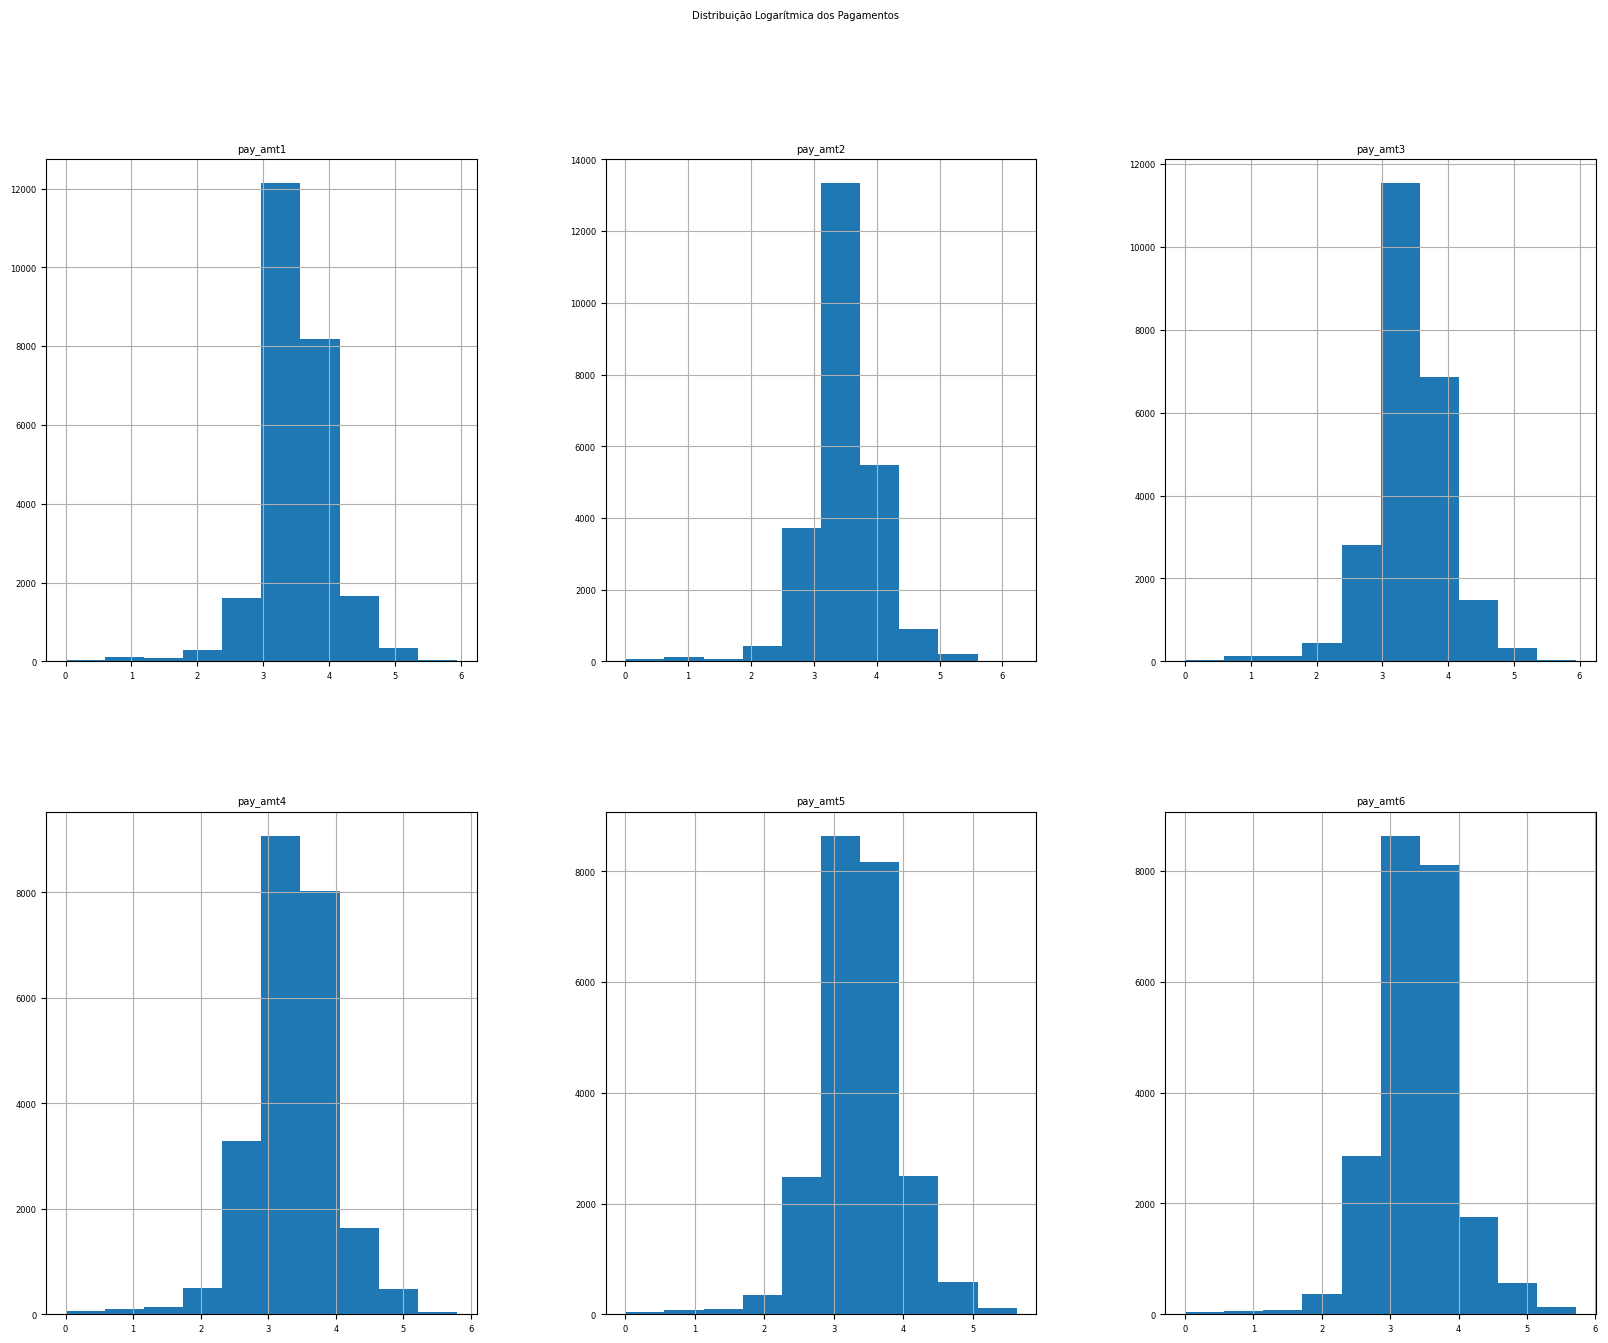

In [50]:
# Aplica uma máscara para remover os valores zero
pay_amt_feats = ['pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']
df3_filtered = df3[df3[pay_amt_feats] > 0]

# Calcula o log10 dos valores para visualização
df3_filtered_log = np.log10(df3_filtered[pay_amt_feats])

# Plota os histogramas
df3_filtered_log.hist(bins=10, layout=(2,3), figsize=(20,15), grid=True)
plt.suptitle('Distribuição Logarítmica dos Pagamentos')
plt.show()

## 4.2 - Análise Bivariada

* Variáveis analisadas após a remoção de colunas irrelevantes:
- **Incluídas**: LIMIT_BAL, SEX, EDUCATION, MARRIAGE, AGE, PAY_1, BILL_AMT1 a BILL_AMT6, PAY_AMT1 a PAY_AMT6, default payment next month.
- **Excluídas**: 
  - `ID` (Identificador, não relevante para análise)
  - `PAY_2` a `PAY_6` (erros na coleta de dados)
  - `EDUCATION_CAT` e variantes (Já incluídas em `EDUCATION`)

* Correlação
- **PAY_1**: Alta correlação com a variável resposta, indicando forte relação com inadimplência.
- **LIMIT_BAL**: Correlação negativa com a variável resposta, sugerindo que limites de crédito maiores estão associados a menor probabilidade de inadimplência.

* Limitações
- A correlação de Pearson não captura bem relações não lineares e é mais adequada para variáveis contínuas.
- Para uma análise mais completa, recomenda-se o uso de matrizes de gráficos de dispersão para identificar relações não lineares e melhorar a compreensão do relacionamento entre as características e a variável resposta.

In [51]:
features_response = df3.columns.tolist()
features_response[::]

['id',
 'limit_bal',
 'sex',
 'education',
 'marriage',
 'age',
 'pay_1',
 'pay_2',
 'pay_3',
 'pay_4',
 'pay_5',
 'pay_6',
 'bill_amt1',
 'bill_amt2',
 'bill_amt3',
 'bill_amt4',
 'bill_amt5',
 'bill_amt6',
 'pay_amt1',
 'pay_amt2',
 'pay_amt3',
 'pay_amt4',
 'pay_amt5',
 'pay_amt6',
 'default payment next month',
 'education_cat',
 'education_graduate school',
 'education_high school',
 'education_others',
 'education_university']

In [52]:
items_to_remove = [ 'id', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 
                    'age_group',
                    'mean_delay',
                    'credit_limit_group',
                    'consecutive_late_payments',
                    'bill_amt_group',
                    'education_cat',
                    'education_graduate school',
                    'education_high school',
                    'education_others',
                    'education_university']

In [53]:
# list comprehesion
features_response = [item for item in features_response if item not in items_to_remove]
features_response

['limit_bal',
 'sex',
 'education',
 'marriage',
 'age',
 'pay_1',
 'bill_amt1',
 'bill_amt2',
 'bill_amt3',
 'bill_amt4',
 'bill_amt5',
 'bill_amt6',
 'pay_amt1',
 'pay_amt2',
 'pay_amt3',
 'pay_amt4',
 'pay_amt5',
 'pay_amt6',
 'default payment next month']

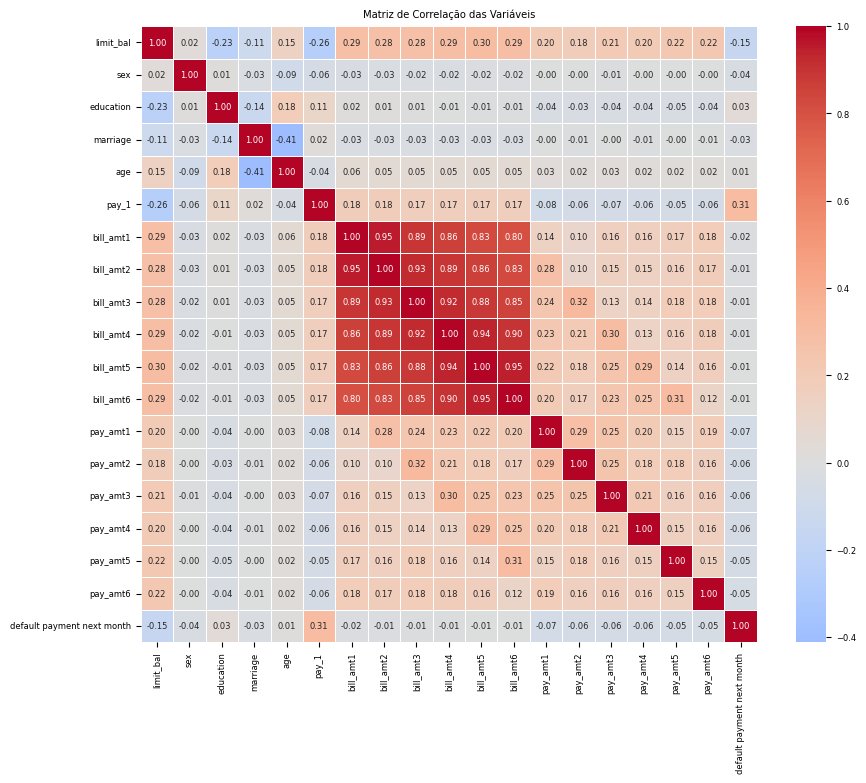

In [54]:
# Calcular a matriz de correlação
corr = df3[features_response].corr()

# Plotar o heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            cmap='coolwarm',  # Colormap para uma visualização mais clara
            annot=True,       # Adiciona os valores das correlações no heatmap
            center=0,         # Centraliza a coloração em 0
            fmt=".2f",       # Formata os valores numéricos
            linewidths=0.5,  # Define a largura das linhas que separam os quadrados
            square=True)     # Torna o heatmap quadrado

plt.title('Matriz de Correlação das Variáveis')
plt.show()

## 4.3 - Análise das Hipóteses

### 4.3.1 - Hipótese 1: Se a idade do cliente aumenta, a probabilidade de inadimplência diminui

* A distribuição de inadimplentes é mais proeminente em faixas etárias mais avançadas (50+),logo, a taxa de inadimplência aumenta com a idade. Embora haja muitos jovens inadimplentes, a taxa de inadimplência em relação ao total de pessoas em cada faixa etária parece aumentar com a idade.
* Para os inadimplentes, a distribuição parece ser mais espalhada, mas também há uma maior concentração entre 20 a 40 anos, com um leve aumento em torno dos 30 anos.
* Em idades mais avançadas (a partir de 50 anos), a contagem de inadimplentes parece mais alta em comparação aos adimplentes, mesmo que o número absoluto de pessoas seja menor.

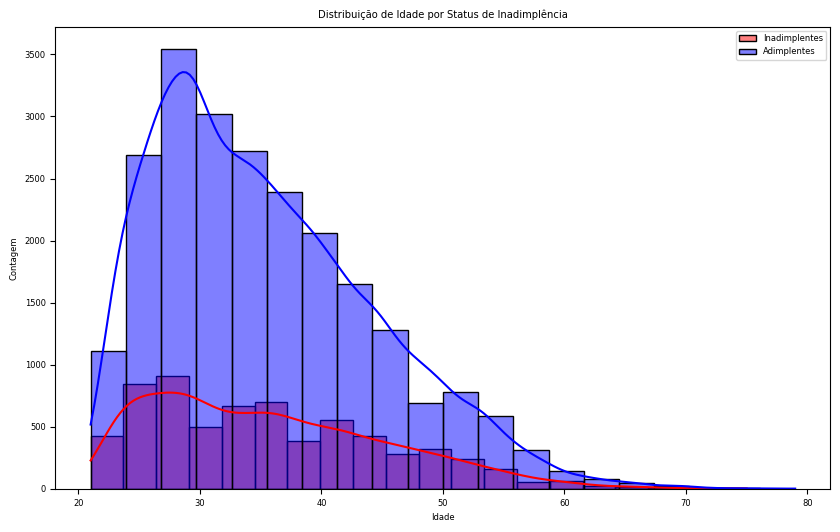

In [55]:
# Plotando a distribuição da inadimplência por faixa etária
plt.figure(figsize=(10, 6))
sns.histplot(df3[df3['default payment next month'] == 1]['age'], bins=20, color='red', label='Inadimplentes', kde=True)
sns.histplot(df3[df3['default payment next month'] == 0]['age'], bins=20, color='blue', label='Adimplentes', kde=True)
plt.title('Distribuição de Idade por Status de Inadimplência')
plt.xlabel('Idade')
plt.ylabel('Contagem')
plt.legend()
plt.show()

In [56]:
# Definindo faixas etárias
df3['age_group'] = pd.cut(df3['age'], bins=[20, 30, 40, 50, 60, 70, 80], labels=['20-30', '30-40', '40-50', '50-60', '60-70', '70-80'])

# Calculando a taxa de inadimplência por faixa etária
age_default_rate = df3.groupby('age_group')['default payment next month'].mean()

# Exibindo o resultado
print("Taxa de inadimplência por faixa etária:")
print(age_default_rate)

Taxa de inadimplência por faixa etária:
age_group
20-30    0.224576
30-40    0.203473
40-50    0.233602
50-60    0.251905
60-70    0.263780
70-80    0.333333
Name: default payment next month, dtype: float64


### 4.3.2 - Hipótese 2: Se o limite de crédito do cliente aumenta, a probabilidade de inadimplência diminui

Esta hipótese é evrdadeira. À medida que o limite de crédito aumenta, a taxa de inadimplência diminui. 
* A taxa de inadimplência entre clientes com limite de crédito até 50 mil é de 31.99%.
* Para aqueles com limite entre 400-500 mil, a inadimplência é de 11.96%.
* E para clientes com limite entre 500 mil e 1 milhão, a inadimplência sobe um pouco para 12.85%, mas ainda é uma das menores.

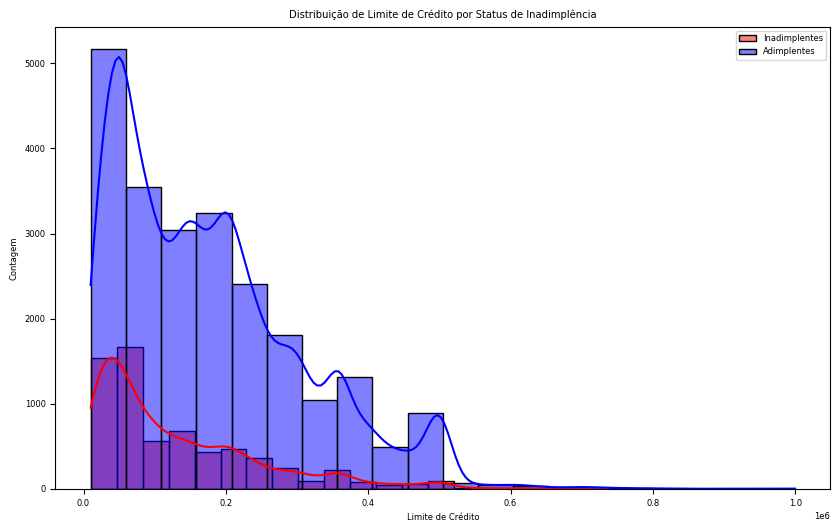

In [57]:
# Plotando a relação entre limite de crédito e inadimplência
plt.figure(figsize=(10, 6))
sns.histplot(df3[df3['default payment next month'] == 1]['limit_bal'], bins=20, color='red', label='Inadimplentes', kde=True)
sns.histplot(df3[df3['default payment next month'] == 0]['limit_bal'], bins=20, color='blue', label='Adimplentes', kde=True)
plt.title('Distribuição de Limite de Crédito por Status de Inadimplência')
plt.xlabel('Limite de Crédito')
plt.ylabel('Contagem')
plt.legend()
plt.show()

In [58]:
# Criando faixas de limite de crédito
df3['credit_limit_group'] = pd.cut(df3['limit_bal'], bins=[0, 50000, 100000, 150000, 200000, 300000, 400000, 500000, 1000000],
                                  labels=['0-50k', '50-100k', '100-150k', '150-200k', '200-300k', '300-400k', '400-500k', '500k-1M'])

# Calculando a taxa de inadimplência por faixa de limite de crédito
credit_limit_default_rate = df3.groupby('credit_limit_group')['default payment next month'].mean()

# Exibindo as taxas de inadimplência por faixa de limite de crédito
print("Taxa de inadimplência por faixa de limite de crédito:")
print(credit_limit_default_rate)

# Para ver também a quantidade de clientes por faixa de crédito
credit_limit_count = df3['credit_limit_group'].value_counts().sort_index()
print("\nQuantidade de clientes por faixa de limite de crédito:")
print(credit_limit_count)

Taxa de inadimplência por faixa de limite de crédito:
credit_limit_group
0-50k       0.318487
50-100k     0.257592
100-150k    0.210540
150-200k    0.177829
200-300k    0.160247
300-400k    0.140402
400-500k    0.122462
500k-1M     0.112195
Name: default payment next month, dtype: float64

Quantidade de clientes por faixa de limite de crédito:
credit_limit_group
0-50k       7589
50-100k     4775
100-150k    3852
150-200k    3942
200-300k    5011
300-400k    2735
400-500k    1576
500k-1M      205
Name: count, dtype: int64


### 4.3.3 - Hipótese 3: Clientes com pagamentos atrasados consecutivos têm maior probabilidade de inadimplência. - HIPÓTESE COMPROMETIDA PELA INTEGRIDADE DOS DADOS EM PAY_2 A PAY_6

* A tendência é clara: quanto mais atrasos consecutivos um cliente tem, maior a chance de inadimplência. A taxa de inadimplência vai de 11,7% (sem atrasos) a 71,1% (6 atrasos consecutivos).
* Isso confirma a hipótese de que há uma correlação positiva significativa entre o número de atrasos consecutivos e a probabilidade de inadimplência. Clientes que atrasam pagamentos repetidamente estão muito mais propensos a não pagar suas faturas no mês seguinte.

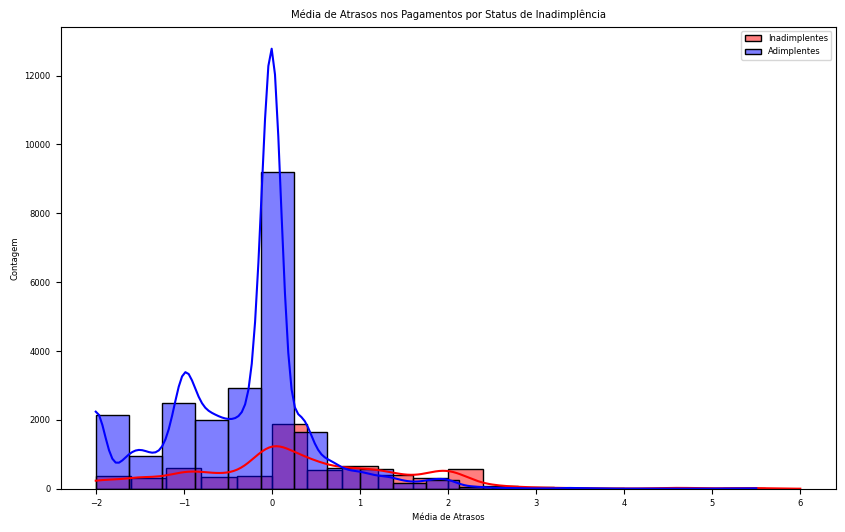

In [59]:
# Calculando a média de atraso nos pagamentos para inadimplentes e adimplentes
df3['mean_delay'] = df3[['pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']].mean(axis=1)

plt.figure(figsize=(10, 6))
sns.histplot(df3[df3['default payment next month'] == 1]['mean_delay'], bins=20, color='red', label='Inadimplentes', kde=True)
sns.histplot(df3[df3['default payment next month'] == 0]['mean_delay'], bins=20, color='blue', label='Adimplentes', kde=True)
plt.title('Média de Atrasos nos Pagamentos por Status de Inadimplência')
plt.xlabel('Média de Atrasos')
plt.ylabel('Contagem')
plt.legend()
plt.show()

In [60]:
# Criar uma coluna que conta os atrasos consecutivos
def count_consecutive_late_payments(row):
    late_payments = [row['pay_1'], row['pay_2'], row['pay_3'], row['pay_4'], row['pay_5'], row['pay_6']]
    count = 0
    max_consecutive = 0
    
    for pay in late_payments:
        if pay > 0:  # Atraso (valores maiores que 0 indicam atraso)
            count += 1
        else:
            max_consecutive = max(max_consecutive, count)
            count = 0

    return max(max_consecutive, count)

# Aplicar a função para contar atrasos consecutivos em cada linha
df3['consecutive_late_payments'] = df3.apply(count_consecutive_late_payments, axis=1)

# Calcular a taxa de inadimplência para diferentes faixas de atrasos consecutivos
consecutive_late_groups = df3.groupby('consecutive_late_payments')['default payment next month'].mean()

# Contar quantos clientes estão em cada faixa de atrasos consecutivos
count_per_group = df3['consecutive_late_payments'].value_counts().sort_index()

print("Taxa de inadimplência por número de atrasos consecutivos:")
print(consecutive_late_groups)

print("\nQuantidade de clientes por número de atrasos consecutivos:")
print(count_per_group)


Taxa de inadimplência por número de atrasos consecutivos:
consecutive_late_payments
0    0.120134
1    0.310933
2    0.416532
3    0.539859
4    0.521193
5    0.596939
6    0.711279
Name: default payment next month, dtype: float64

Quantidade de clientes por número de atrasos consecutivos:
consecutive_late_payments
0    19986
1     4628
2     1863
3      991
4      637
5      392
6     1188
Name: count, dtype: int64


### 4.3.4 - Hipótese 4: Quanto maior o valor da fatura atual, maior a probabilidade de inadimplência no próximo mês

* Tendência geral: A taxa de inadimplência tende a ser mais alta nas faixas de valores de fatura mais baixas, como 0-1k (24.97%) e 10k-20k (24.83%). À medida que o valor da fatura aumenta, a taxa de inadimplência diminui, com a menor taxa (19.49%) sendo observada na faixa mais alta (100k+).

* Faixas intermediárias: Entre 1k e 50k, as taxas de inadimplência variam, mas não apresentam uma tendência clara de aumento ou diminuição. No entanto, os valores mais altos (acima de 50k) têm uma redução na inadimplência.

* Conclusão preliminar: Os dados sugerem que clientes com faturas mais altas têm uma menor probabilidade de inadimplência, especialmente na faixa de valores acima de 50k. Isso pode estar relacionado ao perfil financeiro desses clientes, que possivelmente têm mais recursos para pagar suas faturas.

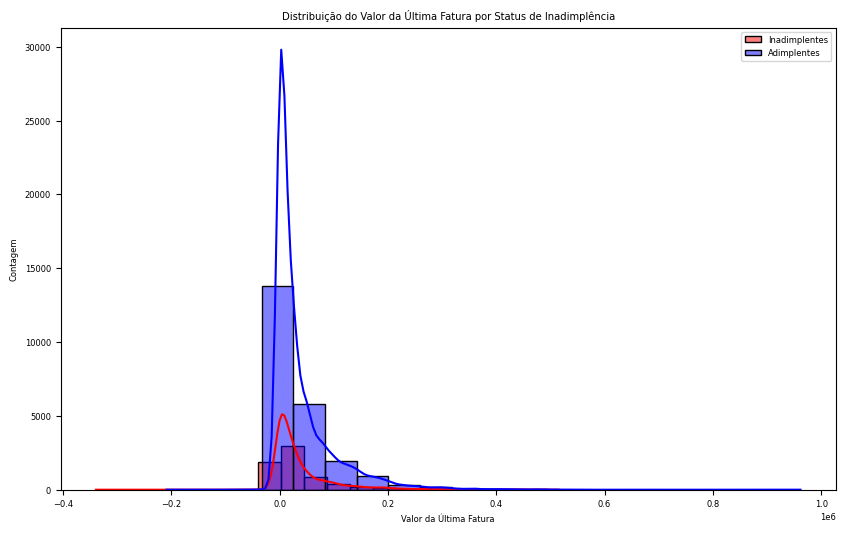

In [61]:
# Plotando a relação entre valor da última fatura e inadimplência
plt.figure(figsize=(10, 6))
sns.histplot(df3[df3['default payment next month'] == 1]['bill_amt6'], bins=20, color='red', label='Inadimplentes', kde=True)
sns.histplot(df3[df3['default payment next month'] == 0]['bill_amt6'], bins=20, color='blue', label='Adimplentes', kde=True)
plt.title('Distribuição do Valor da Última Fatura por Status de Inadimplência')
plt.xlabel('Valor da Última Fatura')
plt.ylabel('Contagem')
plt.legend()
plt.show()

In [62]:
# Criar faixas de valor da fatura (bill_amt1 representa o valor da fatura atual)
df3['bill_amt_group'] = pd.cut(df3['bill_amt1'],
                              bins=[-1, 1000, 5000, 10000, 20000, 30000, 50000, 100000, float('inf')],
                              labels=['0-1k', '1k-5k', '5k-10k', '10k-20k', '20k-30k', '30k-50k', '50k-100k', '100k+'])

# Calcular a taxa de inadimplência por faixa de valor da fatura
default_rate_by_bill_amt = df3.groupby('bill_amt_group')['default payment next month'].mean()

# Contar o número de clientes por faixa de valor da fatura
count_by_bill_amt = df3['bill_amt_group'].value_counts()

# Exibir os resultados
print("Taxa de inadimplência por faixa de valor da fatura:")
print(default_rate_by_bill_amt)

print("\nQuantidade de clientes por faixa de valor da fatura:")
print(count_by_bill_amt)


Taxa de inadimplência por faixa de valor da fatura:
bill_amt_group
0-1k        0.248099
1k-5k       0.206682
5k-10k      0.215881
10k-20k     0.247717
20k-30k     0.235987
30k-50k     0.227006
50k-100k    0.209543
100k+       0.194433
Name: default payment next month, dtype: float64

Quantidade de clientes por faixa de valor da fatura:
bill_amt_group
100k+       4850
50k-100k    4548
0-1k        4208
30k-50k     3577
1k-5k       3532
10k-20k     3504
20k-30k     2462
5k-10k      2418
Name: count, dtype: int64


# 5.0 - Modelagem dos Dados

In [63]:
df4 = df3.copy()

In [64]:
df4.head()

,id,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,...,education_cat,education_graduate school,education_high school,education_others,education_university,age_group,credit_limit_group,mean_delay,consecutive_late_payments,bill_amt_group
0,798fc410-45c1,20000,2,2,1,24,2,2,-1,-1,...,university,False,False,False,True,20-30,0-50k,-0.333333,2,1k-5k
1,8a8c8f3b-8eb4,120000,2,2,2,26,-1,2,0,0,...,university,False,False,False,True,20-30,100-150k,0.500000,1,1k-5k
2,85698822-43f5,90000,2,2,2,34,0,0,0,0,...,university,False,False,False,True,30-40,50-100k,0.000000,0,20k-30k
3,0737c11b-be42,50000,2,2,1,37,0,0,0,0,...,university,False,False,False,True,30-40,0-50k,0.000000,0,30k-50k
4,3b7f77cc-dbc0,50000,1,2,1,57,-1,0,-1,0,...,university,False,False,False,True,50-60,0-50k,-0.333333,0,5k-10k


## 5.1 - Seleção de características

* **PAY_1** --> Essa característica captura valores históricos da variável resposta. Característica como essa são um dos melhores preditores para qualquer problema de ML que use dados históricos para a mesma coisa que estamos tentando prever. Ou seja, as pessoas que já ficaram inadimplentes apresentam maior risco de inadimplir novamente. 
* **LIMIT_BAL** --> clientes que apresentam mais risco devem recebem limites mais baixos para que o credor tenha menos problemas. Logo, podemos esperar uma maior probabilidade de inadimplência para contas com valores menores para LIMIT_BAL.

### 5.1.1 - Teste ANOVA - Manual

* ANOVA (Analysis of Variance) é um teste estatístico que verifica se existe uma diferença significativa entre os grupos de uma variável categórica em relação a uma variável contínua. No caso de f_classif, ele usa ANOVA para calcular a força da associação entre cada feature e a variável de saída (target).

In [65]:
# Seleção de características univariada
X = df4[features_response].iloc[:,:-1].values
y = df4[features_response].iloc[:,-1].values
print(X.shape, y.shape)

(29685, 18) (29685,)


In [66]:
(f_stat, f_p_value) = f_classif(X, y)

In [67]:
f_test_df = pd.DataFrame({'Feature': features_response[:-1], 'F statistic': f_stat, 'p value': f_p_value})
f_test_df.sort_values('p value')

,Feature,F statistic,p value
5,pay_1,3126.713572,0.000000e+00
0,limit_bal,717.548548,3.299091e-156
12,pay_amt1,158.773310,2.598410e-36
13,pay_amt2,100.549372,1.259341e-23
15,pay_amt4,95.463845,1.628663e-22
14,pay_amt3,92.616578,6.832446e-22
16,pay_amt5,89.671119,3.013470e-21
17,pay_amt6,83.172561,7.980774e-20
1,sex,47.982184,4.388731e-12
2,education,34.662525,3.963209e-09


### 5.1.2 - Teste ANOVA - Automático

* No SelectPercentile, estamos usando o ANOVA F-value de maneira automatizada para selecionar as melhores features, mas com a diferença de que está filtrando um percentual específico de features com as maiores pontuações de F-value.
* SelectPercentile não executa uma ANOVA manual para cada feature separadamente, mas aplica a ANOVA para todas as features de forma massiva e, em seguida, seleciona as que obtiveram melhor desempenho, ou seja, aquelas com maior F-value.

In [68]:
# Selecionando as 20% melhores features
selector = SelectPercentile(f_classif, percentile=20)

# Ajustando o objeto às características e aos dados da resposta
selector.fit(X, y)

# Pegando os nomes das características
best_feature = selector.get_support() 
features = features_response[:-1]  # nome de todas características exceto o último (variável resposta)
best_feature = [features[counter] for counter in range(len(features)) if best_feature[counter]]
best_feature

['limit_bal', 'pay_1', 'pay_amt1', 'pay_amt2']

### 5.1.3 - Random Forest Classifier

In [69]:
# Modelo Random Forest
model = RandomForestClassifier()
model.fit(X, y)

# Importância das variáveis
feature_names = ['limit_bal',
 'sex',
 'education',
 'marriage',
 'age',
 'pay_1',
 'bill_amt1',
 'bill_amt2',
 'bill_amt3',
 'bill_amt4',
 'bill_amt5',
 'bill_amt6',
 'pay_amt1',
 'pay_amt2',
 'pay_amt3',
 'pay_amt4',
 'pay_amt5',
 'pay_amt6']
feature_importances = model.feature_importances_

# Criação de um DataFrame para exibir as importâncias
features = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(features)

      Feature  Importance
5       pay_1    0.134303
4         age    0.070176
6   bill_amt1    0.067506
0   limit_bal    0.067361
12   pay_amt1    0.063397
7   bill_amt2    0.062515
8   bill_amt3    0.059904
13   pay_amt2    0.057548
9   bill_amt4    0.056854
11  bill_amt6    0.056409
10  bill_amt5    0.055436
14   pay_amt3    0.051990
17   pay_amt6    0.050464
15   pay_amt4    0.049834
16   pay_amt5    0.048987
2   education    0.020589
3    marriage    0.014126
1         sex    0.012601


## 5.2 - Examinando as melhores características

### 5.2.1 - Pay_1

In [70]:
# Visualizando o relacionamento entre as características e a resposta
overall_default_rate = df4['default payment next month'].mean() # calculando a linha se base da variável respota para a taxa de inadimplência
overall_default_rate

np.float64(0.22105440458143844)

In [71]:
# Taxas de inadimplência para diferentes valores de PAY_1
group_bt_pay_mean_y = df4.groupby('pay_1').agg({'default payment next month': np.mean})
group_bt_pay_mean_y 

,default payment next month
pay_1,
-2,0.131664
-1,0.170002
0,0.144462
1,0.336400
2,0.694701
3,0.773973
4,0.682540
5,0.434783
6,0.545455


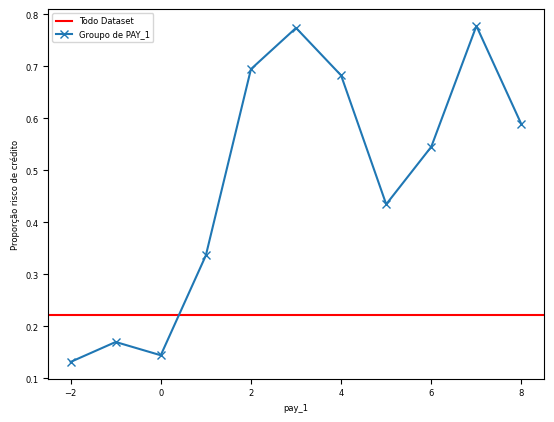

In [72]:
# plotando o gráfico
axes = plt.axes()
# plotando a taxa de inadimplência geral (linha vermelha)
axes.axhline(overall_default_rate, color='red')
# taxa de inadimplência PAY_1
group_bt_pay_mean_y.plot(marker='x', legend=False, ax=axes)
axes.set_ylabel('Proporção risco de crédito')
axes.legend(['Todo Dataset', 'Groupo de PAY_1'])

* Tese confirmada:quem já inadimpliu tem tendência a inadimplir novamente.
  - Pelo menos 30% das contas que estavam inadimplentes no último mês estarão inadimplentes novamente no próximo mês. 

### 5.2.2 - Limite_bal

1. **Gráficos comparativos**: 
   - O primeiro gráfico (não normalizado) mostra a contagem real de contas em cada intervalo de limite de crédito.
   - O segundo gráfico (normalizado) mostra a distribuição relativa, permitindo comparar as proporções de contas inadimplentes e não inadimplentes, independentemente do tamanho da amostra. A normalização aqui, transforma as contagens em uma **função de densidade de probabilidade (PDF)**. Assim, a área sob o gráfico será igual a 1, pois a soma das probabilidades será 1.

2. **Análise de limite de crédito**:
   - Contas com **limites de crédito abaixo de 150.000** tendem a ter maior propensão à inadimplência.
   - Como essa parece ser uma característica importante para o modelo preditivo, esses gráficos podem ser úteis na apresentação final para o cliente.

3. **Importância da visualização**: Apresentações visuais eficazes ajudam a **comunicar rapidamente insights importantes** para o cliente e podem ser um diferencial no processo de tomada de decisão.

In [73]:
bin_edges = list(range(0,850000,50000))
print(bin_edges[-1])

800000


In [74]:
# Criando máscras lógicas para amostras positivas e negativas
pos_mask = y==1
neg_mask = y==0

Text(0.5, 1.0, 'Credit limits by response variable')

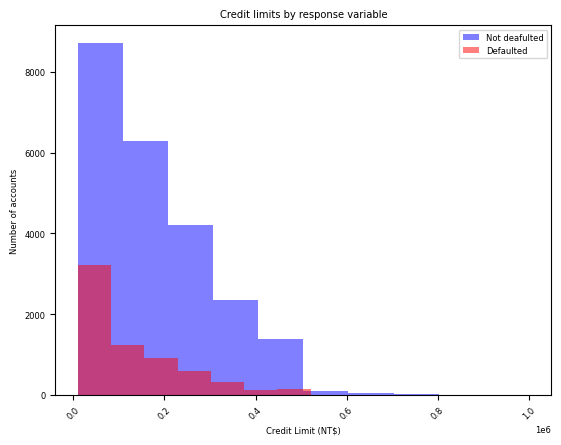

In [75]:
axes = plt.axes()
axes.hist(df4.loc[neg_mask, 'limit_bal'], alpha=0.5, color='blue')
axes.hist(df4.loc[pos_mask, 'limit_bal'], alpha=0.5, color='red')
axes.tick_params(axis='x', labelrotation=45)
axes.set_xlabel('Credit Limit (NT$)')
axes.set_ylabel('Number of accounts')
axes.legend(['Not deafulted', 'Defaulted'])
axes.set_title('Credit limits by response variable')

Text(0.5, 1.0, 'Normalized distributions of credit limits by response variable')

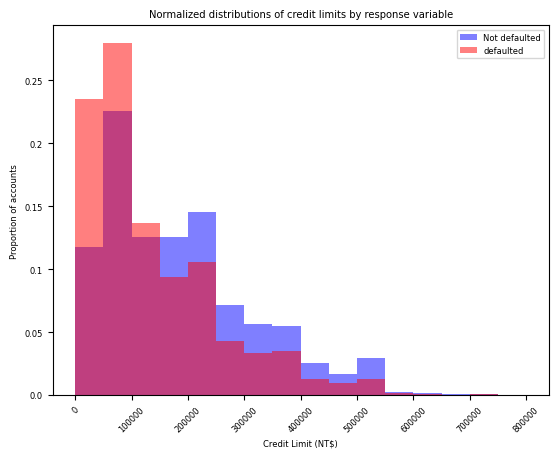

In [76]:
axes = plt.axes()
axes.hist(df4.loc[neg_mask, 'limit_bal'], bins=bin_edges, alpha=0.5, density=True, color='blue')
axes.hist(df4.loc[pos_mask,'limit_bal'], bins=bin_edges, alpha=0.5, density=True, color='red')
axes.tick_params(axis='x', labelrotation=45)
axes.set_xlabel('Credit Limit (NT$)')
axes.set_ylabel('Proportion of accounts')
y_ticks = axes.get_yticks()
axes.set_yticklabels(np.round(y_ticks*50000, 2))
axes.legend(['Not defaulted', 'defaulted'])
axes.set_title('Normalized distributions of credit limits by response variable')

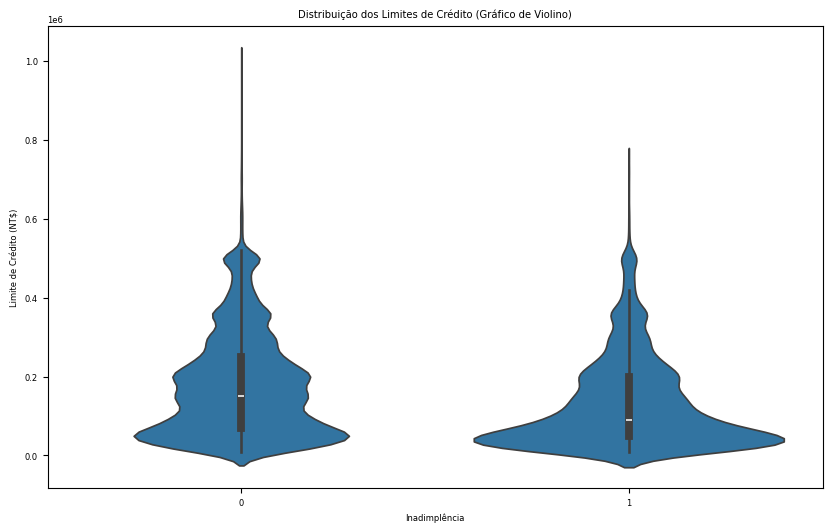

In [77]:
plt.figure(figsize=(10,6))
sns.violinplot(x='default payment next month', y='limit_bal', data=df4)
plt.title('Distribuição dos Limites de Crédito (Gráfico de Violino)')
plt.xlabel('Inadimplência')
plt.ylabel('Limite de Crédito (NT$)')
plt.show()


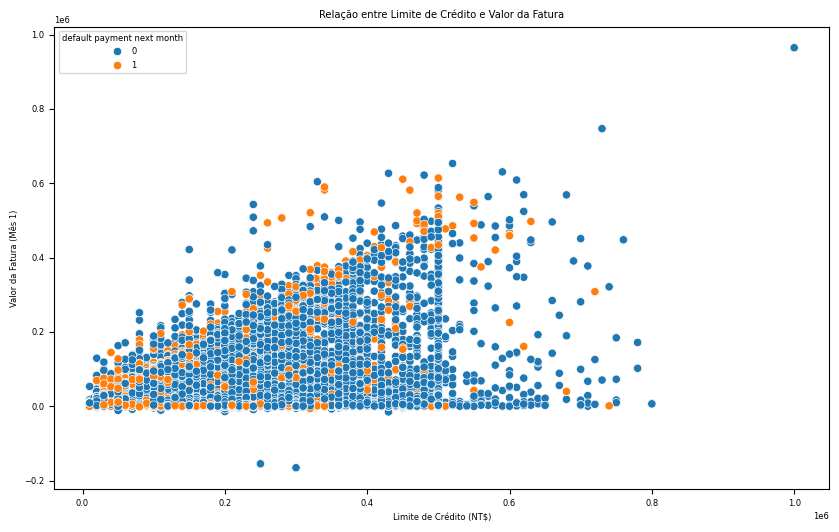

In [78]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='limit_bal', y='bill_amt1', hue='default payment next month', data=df4)
plt.title('Relação entre Limite de Crédito e Valor da Fatura')
plt.xlabel('Limite de Crédito (NT$)')
plt.ylabel('Valor da Fatura (Mês 1)')
plt.show()

## 5.3 - Balanceamento dos Dados

* Os dados estão desbalanceados e, na classificação binária, os datasets são descritos considerando se eles estão balanceados ou desbalanceados. 
* A maioria dos modelos de clasificação de Machine Learning é projetada para operar com dados balanceados (uma divisão 50/50 entre as classes).
* Aplicaremos o balanceamento por ponderação (dentro do modelo, na próxima etapa).

In [79]:
df5 = df4.copy()

In [80]:
proportion_positive = df4['default payment next month'].mean()
proportion_positive

np.float64(0.22105440458143844)

In [81]:
class_counts = df4.groupby('default payment next month')['id'].count()
class_counts

default payment next month
0    23123
1     6562
Name: id, dtype: int64

### 5.3.1 - Oversampling com SMOTE

In [82]:
# from imblearn.over_sampling import SMOTE

# # Inicializa o SMOTE
# smote = SMOTE(sampling_strategy='minority')

# # Aplica o SMOTE ao conjunto de treino
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

### 5.3.2 - Undersampling com RandomUnderSampler

In [83]:
# from imblearn.under_sampling import RandomUnderSampler

# # Inicializa o RandomUnderSampler
# undersample = RandomUnderSampler(sampling_strategy='majority')

# # Aplica o RandomUnderSampler ao conjunto de treino
# X_train_resampled, y_train_resampled = undersample.fit_resample(X_train, y_train)

### 5.3.3 - Modelos treinados com Under e Over samples

In [84]:
# # Treinamento com SMOTE
# model_lr_smote = LogisticRegression()
# model_lr_smote.fit(X_train_resampled, y_train_resampled)

# # Predição e avaliação
# y_pred_lr_smote = model_lr_smote.predict(X_test)
# accuracy_lr_smote = accuracy_score(y_test, y_pred_lr_smote)
# roc_auc_lr_smote = roc_auc_score(y_test, model_lr_smote.predict_proba(X_test)[:, 1])

# # Treinamento com RandomUnderSampler
# model_lr_under = LogisticRegression()
# model_lr_under.fit(X_train_resampled, y_train_resampled)

# # Predição e avaliação
# y_pred_lr_under = model_lr_under.predict(X_test)
# accuracy_lr_under = accuracy_score(y_test, y_pred_lr_under)
# roc_auc_lr_under = roc_auc_score(y_test, model_lr_under.predict_proba(X_test)[:, 1])

In [85]:
# # Treinamento com SMOTE
# model_dt_smote = DecisionTreeClassifier()
# model_dt_smote.fit(X_train_resampled, y_train_resampled)

# # Predição e avaliação
# y_pred_dt_smote = model_dt_smote.predict(X_test)
# accuracy_dt_smote = accuracy_score(y_test, y_pred_dt_smote)
# roc_auc_dt_smote = roc_auc_score(y_test, model_dt_smote.predict_proba(X_test)[:, 1])

# # Treinamento com RandomUnderSampler
# model_dt_under = DecisionTreeClassifier()
# model_dt_under.fit(X_train_resampled, y_train_resampled)

# # Predição e avaliação
# y_pred_dt_under = model_dt_under.predict(X_test)
# accuracy_dt_under = accuracy_score(y_test, y_pred_dt_under)
# roc_auc_dt_under = roc_auc_score(y_test, model_dt_under.predict_proba(X_test)[:, 1])

In [86]:
# # Treinamento com SMOTE
# model_rf_smote = RandomForestClassifier()
# model_rf_smote.fit(X_train_resampled, y_train_resampled)

# # Predição e avaliação
# y_pred_rf_smote = model_rf_smote.predict(X_test)
# accuracy_rf_smote = accuracy_score(y_test, y_pred_rf_smote)
# roc_auc_rf_smote = roc_auc_score(y_test, model_rf_smote.predict_proba(X_test)[:, 1])

# # Treinamento com RandomUnderSampler
# model_rf_under = RandomForestClassifier()
# model_rf_under.fit(X_train_resampled, y_train_resampled)

# # Predição e avaliação
# y_pred_rf_under = model_rf_under.predict(X_test)
# accuracy_rf_under = accuracy_score(y_test, y_pred_rf_under)
# roc_auc_rf_under = roc_auc_score(y_test, model_rf_under.predict_proba(X_test)[:, 1])

# 6.0 - ALGORITIMOS DE MACHINE LEARNING

In [87]:
# # Filtrando as melhores características e a variável resposta
# X = df5[['pay_1', 'limit_bal', 'age', 'bill_amt1']]
# # X = df5[['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_1', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4']]
# # # X = df5[['limit_bal', 'pay_1', 'pay_amt1', 'pay_amt2']]
# # X = df5[['limit_bal', 'pay_1']]
# y = df5['default payment next month']

# # Dividindo os dados em conjunto de treino e teste
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [88]:
X_train, X_test, y_train, y_test = \
train_test_split(
    df5[features_response[:-1]].values,
    df5['default payment next month'].values,
test_size=0.2, random_state=24)

In [89]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

## 6.1 - Regressão Logística

In [90]:
# Treinamento com ponderação de amostras
model_lr_weighted = LogisticRegression(class_weight='balanced')
model_lr_weighted.fit(X_train, y_train)

# Predição e avaliação
y_pred_lr_weighted = model_lr_weighted.predict(X_test)
accuracy_lr_weighted = accuracy_score(y_test, y_pred_lr_weighted)
roc_auc_lr_weighted = roc_auc_score(y_test, model_lr_weighted.predict_proba(X_test)[:, 1])

## 6.2 - Àrvore de Decisão

In [91]:
# Treinamento com ponderação de amostras
model_dt_weighted = DecisionTreeClassifier(class_weight='balanced')
model_dt_weighted.fit(X_train, y_train)

# Predição e avaliação
y_pred_dt_weighted = model_dt_weighted.predict(X_test)
accuracy_dt_weighted = accuracy_score(y_test, y_pred_dt_weighted)
roc_auc_dt_weighted = roc_auc_score(y_test, model_dt_weighted.predict_proba(X_test)[:, 1])

## 6.3 - Floresta Aleatória

In [92]:
# Treinamento com ponderação de amostras
model_rf_weighted = RandomForestClassifier(class_weight='balanced')
model_rf_weighted.fit(X_train, y_train)

# Predição e avaliação
y_pred_rf_weighted = model_rf_weighted.predict(X_test)
accuracy_rf_weighted = accuracy_score(y_test, y_pred_rf_weighted)
roc_auc_rf_weighted = roc_auc_score(y_test, model_rf_weighted.predict_proba(X_test)[:, 1])


In [93]:
# metricas = classification_report(y_test, y_pred_rf_weighted)
# print(metricas) # metrics

## 6.4 - Avaliação dos Modelos

- Há um custo mais alto associado à não identificação correta das contas que ficarão inadimplentes? 
- Ou é mais importante identificar corretamente as contas que não estarão inadimplentes?

* Para o problema de negócio em questão utilizaremos a ROC AUC como métrica de avaliação:
  
1. **Desequilíbrio de classes**: A ROC AUC é particularmente útil em problemas com dados desbalanceados, como este, onde a proporção de inadimplentes (classe 1) é menor em relação aos adimplentes (classe 0). Ao contrário da acurácia, que pode ser enganadora em conjuntos de dados desbalanceados (onde o modelo pode acertar a maioria das previsões simplesmente prevendo a classe majoritária), o ROC AUC mede a capacidade do modelo de distinguir entre as classes, independentemente desse desequilíbrio.

2. **Sensibilidade e Especificidade**: A ROC AUC analisa o trade-off entre taxa de verdadeiros positivos (sensibilidade) e taxa de falsos positivos (1 - especificidade) em diferentes limiares. Isso significa que ela considera tanto os falsos negativos quanto os falsos positivos, o que é crucial neste caso, pois prever falsamente que um cliente não vai inadimplir pode ter consequências importantes. **Em outros termos, para este problema de negócio há um custo mais alto associado à não identificação correta das contas que ficarão inadimplentes.**

3. **Avaliação Geral**: O ROC AUC dá uma visão geral do desempenho do modelo em prever corretamente as classes, sem ser influenciado por uma divisão específica do conjunto de dados. Ele mede a qualidade das previsões de probabilidade, o que é essencial quando se deseja não apenas classificar corretamente, mas também entender o quão confiante o modelo está em suas previsões.

In [94]:
# Resultados para Regressão Logística
print("\nRegressão Logística com Ponderação")
print(f"Acurácia: {accuracy_lr_weighted:.4f}")
print(f"ROC AUC: {roc_auc_lr_weighted:.4f}")

# Resultados para Decision Tree
print("\nDecision Tree com Ponderação")
print(f"Acurácia: {accuracy_dt_weighted:.4f}")
print(f"ROC AUC: {roc_auc_dt_weighted:.4f}")

# Resultados para Random Forest
print("\nRandom Forest com Ponderação")
print(f"Acurácia: {accuracy_rf_weighted:.4f}")
print(f"ROC AUC: {roc_auc_rf_weighted:.4f}")



Regressão Logística com Ponderação
Acurácia: 0.5552
ROC AUC: 0.6555

Decision Tree com Ponderação
Acurácia: 0.7315
ROC AUC: 0.6106

Random Forest com Ponderação
Acurácia: 0.8120
ROC AUC: 0.7535


## 6.5 - Cross Validation

In [95]:
def evaluate_model(model, X, y, cv=5):
    accuracy_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    roc_auc_scores = cross_val_score(model, X, y, cv=cv, scoring=make_scorer(roc_auc_score))
    return accuracy_scores.mean(), roc_auc_scores.mean()

#RL
pipeline_lr_weighted = Pipeline(steps=[('model', LogisticRegression(class_weight='balanced'))])
# Avaliar o modelo com Cross Validation
accuracy_lr_weighted, roc_auc_lr_weighted = evaluate_model(pipeline_lr_weighted, X, y)

# DT
pipeline_dt_weighted = Pipeline(steps=[('model', DecisionTreeClassifier(class_weight='balanced'))])
# Avaliar o modelo com Cross Validation
accuracy_dt_weighted, roc_auc_dt_weighted = evaluate_model(pipeline_dt_weighted, X, y)

# RF
pipeline_rf_weighted = Pipeline(steps=[('model', RandomForestClassifier(class_weight='balanced'))])
# Avaliar o modelo com Cross Validation
accuracy_rf_weighted, roc_auc_rf_weighted = evaluate_model(pipeline_rf_weighted, X, y)


# Mostrando os resultados
print(f"CV Regressão Logística com Ponderação - Acurácia: {accuracy_lr_weighted:.4f}, ROC AUC: {roc_auc_lr_weighted:.4f}")
print(f"CV Decision Tree com Ponderação - Acurácia: {accuracy_dt_weighted:.4f}, ROC AUC: {roc_auc_dt_weighted:.4f}")
print(f"CV Random Forest com Ponderação - Acurácia: {accuracy_rf_weighted:.4f}, ROC AUC: {roc_auc_rf_weighted:.4f}")

CV Regressão Logística com Ponderação - Acurácia: 0.5766, ROC AUC: 0.6106
CV Decision Tree com Ponderação - Acurácia: 0.7267, ROC AUC: 0.6021
CV Random Forest com Ponderação - Acurácia: 0.8128, ROC AUC: 0.6331


In [96]:
# from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.pipeline import Pipeline

# # Dividir dados
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Aplicar balanceamento usando SMOTE
# smote = SMOTE(sampling_strategy='minority')
# X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# # Aplicar balanceamento usando RandomUnderSampler
# undersample = RandomUnderSampler(sampling_strategy='majority')
# X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)

# # Aplicar balanceamento usando ponderação
# model_weighted = LogisticRegression(class_weight='balanced')

In [97]:
# from sklearn.metrics import roc_auc_score, make_scorer
# from sklearn.model_selection import cross_val_score
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier

# def evaluate_model(model, X, y):
#     scores = cross_val_score(model, X, y, cv=5, scoring=make_scorer(roc_auc_score))
#     return scores.mean()

# # Modelos para avaliar
# models = {
#     "Logistic Regression (SMOTE)": LogisticRegression(),
#     "Decision Tree (SMOTE)": DecisionTreeClassifier(),
#     "Random Forest (SMOTE)": RandomForestClassifier(),
#     "Logistic Regression (Undersampling)": LogisticRegression(),
#     "Decision Tree (Undersampling)": DecisionTreeClassifier(),
#     "Random Forest (Undersampling)": RandomForestClassifier(),
#     "Logistic Regression (Weighted)": LogisticRegression(class_weight='balanced'),
#     "Decision Tree (Weighted)": DecisionTreeClassifier(class_weight='balanced'),
#     "Random Forest (Weighted)": RandomForestClassifier(class_weight='balanced')
# }

# # Avaliar modelos com SMOTE
# for model_name, model in models.items():
#     if 'SMOTE' in model_name:
#         model.fit(X_train_smote, y_train_smote)
#         score = evaluate_model(model, X_test, y_test)
#         print(f"{model_name} - ROC AUC: {score:.4f}")
    
#     elif 'Undersampling' in model_name:
#         model.fit(X_train_under, y_train_under)
#         score = evaluate_model(model, X_test, y_test)
#         print(f"{model_name} - ROC AUC: {score:.4f}")
    
#     else:  # Modelos com ponderação
#         model.fit(X_train, y_train)
#         score = evaluate_model(model, X_test, y_test)
#         print(f"{model_name} - ROC AUC: {score:.4f}")


# 7.0 - HIPER PARÂMETROS

In [98]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split, KFold, GridSearchCV
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import make_scorer, roc_auc_score

# # Dividindo os dados em conjunto de treino e teste
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Aplicando a normalização apenas nos dados de treino
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Definir o número de divisões para a validação cruzada
# cv = KFold(n_splits=5, shuffle=True, random_state=42)

# # Definir a métrica de avaliação como ROC AUC
# roc_auc = make_scorer(roc_auc_score)

# # Hiperparâmetros para Regressão Logística
# param_grid_lr = {
#     'solver': ['saga', 'liblinear'],
#     'penalty': ['l1', 'l2'],
#     'C': [0.01, 0.1, 1, 10, 100]
# }

# # Hiperparâmetros para Árvore de Decisão
# param_grid_dt = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [None, 10, 20, 30, 40],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Hiperparâmetros para Random Forest
# param_grid_rf = {
#     'n_estimators': [100, 200, 400],  # Teste com mais estimadores
#     'max_depth': [3, 9, 12],  # Varie entre menores e maiores profundidades
#     'min_samples_split': [2, 5, 10],  # Permitir divisão com diferentes tamanhos de amostra
#     'min_samples_leaf': [1, 2, 4],  # Tente aumentar o tamanho mínimo da folha
#     'max_features': ['sqrt', 'log2'],  # Continue testando diferentes seleções de features
#     'bootstrap': [True],  # Testar com ou sem bootstrap
#     'criterion': ['gini'],  # Testar os dois critérios de impureza
#     'class_weight': [None, 'balanced']  # Comparar o modelo com e sem balanceamento automático
# }

# # Instanciar os modelos
# lr = LogisticRegression(max_iter=1000, class_weight='balanced')
# dt = DecisionTreeClassifier(class_weight='balanced')
# rf = RandomForestClassifier(class_weight='balanced')

# # GridSearchCV para cada modelo
# grid_lr = GridSearchCV(lr, param_grid_lr, scoring=roc_auc, cv=cv, n_jobs=-1)
# grid_dt = GridSearchCV(dt, param_grid_dt, scoring=roc_auc, cv=cv, n_jobs=-1)
# grid_rf = GridSearchCV(rf, param_grid_rf, scoring=roc_auc, cv=cv, n_jobs=-1)

# # Ajustar o GridSearchCV aos dados de treino
# print("Treinando o modelo Logistic Regression...")
# grid_lr.fit(X_train_scaled, y_train)

# print("Treinando o modelo Decision Tree...")
# grid_dt.fit(X_train_scaled, y_train)

# print("Treinando o modelo Random Forest...")
# grid_rf.fit(X_train_scaled, y_train)

# # Mostrar os melhores hiperparâmetros e o melhor score para cada modelo
# print("Melhores hiperparâmetros para Logistic Regression:", grid_lr.best_params_)
# print("Melhor ROC AUC para Logistic Regression:", grid_lr.best_score_)

# print("Melhores hiperparâmetros para Decision Tree:", grid_dt.best_params_)
# print("Melhor ROC AUC para Decision Tree:", grid_dt.best_score_)

# print("Melhores hiperparâmetros para Random Forest:", grid_rf.best_params_)
# print("Melhor ROC AUC para Random Forest:", grid_rf.best_score_)

# # Avaliação final no conjunto de teste
# best_lr = grid_lr.best_estimator_
# best_dt = grid_dt.best_estimator_
# best_rf = grid_rf.best_estimator_

# print("Avaliação no conjunto de teste:")
# print("ROC AUC Logistic Regression:", roc_auc_score(y_test, best_lr.predict_proba(X_test_scaled)[:, 1]))
# print("ROC AUC Decision Tree:", roc_auc_score(y_test, best_dt.predict_proba(X_test_scaled)[:, 1]))
# print("ROC AUC Random Forest:", roc_auc_score(y_test, best_rf.predict_proba(X_test_scaled)[:, 1]))

## 7.1 - Guardando os melhores hiper parâmetros

In [99]:
# # Salvar os melhores hiperparâmetros
# best_params = {
#     'logistic_regression': grid_lr.best_params_,
#     'decision_tree': grid_dt.best_params_,
#     'random_forest': grid_rf.best_params_
# }
# joblib.dump(best_params, 'best_hyperparameters.pkl')

In [100]:
# Carregando os hiperparâmetros salvos
best_params = joblib.load('best_and_final_models/best_hyperparameters.pkl')
best_params

{'logistic_regression': {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'},
 'decision_tree': {'criterion': 'gini',
  'max_depth': 10,
  'min_samples_leaf': 1,
  'min_samples_split': 5},
 'random_forest': {'bootstrap': True,
  'class_weight': 'balanced',
  'criterion': 'gini',
  'max_depth': 9,
  'max_features': 'log2',
  'min_samples_leaf': 4,
  'min_samples_split': 10,
  'n_estimators': 400}}

# 8.0 - TREINANDO O MODELO FINAL 

In [101]:
# Treinando o modelo final
# Melhor modelo de Random Forest com os hiperparâmetros encontrados
best_rf = RandomForestClassifier(
    bootstrap=True,
    max_depth=9,
    criterion='gini',
    max_features='log2',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_weight_fraction_leaf=0.0,
    min_samples_leaf=4,
    min_samples_split=10,
    n_estimators=400,
    n_jobs=None,
    oob_score=False,
    verbose=1,
    warm_start=False,
    class_weight='balanced',  # Caso esteja lidando com dados desbalanceados
    random_state=4
)

# Treinar o modelo final com os dados de treino completos
best_rf.fit(X_train, y_train)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    8.0s


RandomForestClassifier(class_weight='balanced', max_depth=9,
                       max_features='log2', min_samples_leaf=4,
                       min_samples_split=10, n_estimators=400, random_state=4,
                       verbose=1)

In [102]:
# Fazendo as previsões com o modelo final
# Fazer previsões no conjunto de teste
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]  # Probabilidade para a classe positiva

# Avaliar o modelo com a métrica ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC no conjunto de teste:", roc_auc)

# Confusion Matrix
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

# Relatório de Classificação
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


ROC AUC no conjunto de teste: 0.7711850867819353
Matriz de Confusão:
[[3818  756]
 [ 572  791]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      4574
           1       0.51      0.58      0.54      1363

    accuracy                           0.78      5937
   macro avg       0.69      0.71      0.70      5937
weighted avg       0.79      0.78      0.78      5937



[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s


In [103]:
# # Salvando o melhor modelo Random Forest treinado
# joblib.dump(best_rf, 'best_and_final_models/final_random_forest_model.pkl')

limit_bal: 0.0813
sex: 0.0035
education: 0.0073
marriage: 0.0042
age: 0.0212
pay_1: 0.3550
bill_amt1: 0.0466
bill_amt2: 0.0457
bill_amt3: 0.0371
bill_amt4: 0.0328
bill_amt5: 0.0328
bill_amt6: 0.0307
pay_amt1: 0.0729
pay_amt2: 0.0665
pay_amt3: 0.0509
pay_amt4: 0.0441
pay_amt5: 0.0348
pay_amt6: 0.0327


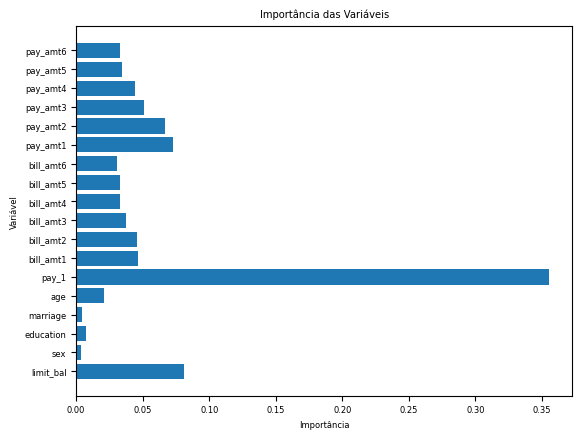

In [104]:
importances = best_rf.feature_importances_
feature_names = df5[features_response[:-1]].columns

# Exibir importância das variáveis
for feature, importance in zip(feature_names, importances):
    print(f'{feature}: {importance:.4f}')
    
# Visualizar a importância das variáveis
plt.barh(feature_names, importances)
plt.xlabel("Importância")
plt.ylabel("Variável")
plt.title("Importância das Variáveis")
plt.show()

# 9.0 - Análise Financeira do Modelo

* **<u>APLICAÇÃO DAS PROBABILIDADES PREVISTAS</u>**:
  1. As probabilidades previstas em um modelo de classificação binária podem ser utilizadas para tomar decisões estratégicas sobre o gerenciamento de contas.
  2. Se as decisões forem simples, de sim/não, a seleção de um único limite de probabilidade será suficiente. Contudo, se houver mais de dois níveis de atividade envolvidos, pode ser necessário definir múltiplos limites (ex.: baixo, médio e alto risco).

* **<u>OBJETIVOS DO CLIENTE</u>**:
  1. **Decisões a serem tomadas**: O cliente deseja um modelo que ajude na identificação de contas de alto risco, visando reduzir a inadimplência e melhorar o gerenciamento financeiro.
  2. **Orientação do modelo**: O cliente pretende utilizar as previsões do modelo para decidir quais clientes devem ser contatados para receber aconselhamento de crédito, especialmente aqueles com maior risco de inadimplência.

* **<u>CUSTOS & BENEFÍCIOS</u>**:
  1. **Custos da Adoção**: É crucial avaliar os custos associados a diferentes ações baseadas nas orientações do modelo.
  2. **Benefícios Potenciais**: As ações bem-sucedidas resultantes do uso do modelo podem levar a economias significativas, evitando perdas associadas à inadimplência.

* **<u>ESTRATÉGIAS DE ACONSELHAMENTO</u>**:
  1. O cliente propõe um programa de aconselhamento para contas de alto risco, com um custo de NT$ 7.500,00 por sessão e uma taxa de sucesso esperada de 70% dos atendidos
  2. Os benefícios potenciais incluem:
       - **Redução da percepção de perda nas cobranças mensais de contas que, se não fosse o aconselhamento, poderiam ter se tornado inadimplentes**.
       - **Possibilidade de estimar quantas sessões de aconselhamento seriam necessárias, baseado na análise de risco do modelo**.

* **<u>ANÁLISE ECONÔMICA</u>**:
  1. Para calcular a economia com a não inadimplência, devemos considerar a fatura do próximo mês, estimando a economia com base no valor médio das faturas mais recentes. Supondo que não haja uma relação forte entre o valor da fatura e a inadimplência, essa abordagem deve ser válida.
  2. A maior economia é gerada ao definir um limite entre 0,42 e 0,47.
  3. Aumentar o limite de 0,42 para 0,47 significa contatar apenas clientes de maior risco (probabilidades >0,47), reduzindo o número de atendimentos e, consequentemente, o custo do programa. Essa estratégia pode resultar em uma economia líquida superior a NT$ 16 milhões, que deve ser dimensionada de acordo com o número total de contas do cliente.

* **<u>INSIGHTS DA ANÁLISE</u>**:
    1. **Melhor threshold encontrado**: O gráfico da economia líquida em função do threshold mostra que o melhor valor de threshold é 0.47. Esse ponto maximiza a economia líquida, proporcionando um balanço ideal entre sinalizar inadimplentes e minimizar perdas com clientes erradamente classificados.

    2. **Maior economia líquida possível**: A maior economia líquida alcançada foi de **NT$ 16.901.935,86**. Esse valor reflete a economia ao aplicar o modelo com o threshold ótimo, garantindo a maximização dos benefícios ao prever inadimplentes.

    3. **Custo total das inadimplências**: O custo total das inadimplências foi de **NT$ 69.630.495,33**. Esse valor corresponde ao custo associado aos clientes inadimplentes, sem qualquer intervenção do modelo preditivo.

    4. **Redução percentual da inadimplência**: Com o modelo ajustado e utilizando o threshold de 0.47, foi possível reduzir a inadimplência em **24,27%**. Isso representa uma redução significativa no custo total associado à inadimplência, refletindo a eficácia do programa de aconselhamento baseado na modelagem preditiva.

    5. **Economia líquida por conta**: A economia líquida por conta foi calculada em **NT$ 2.846,88**, mostrando o impacto financeiro médio por cliente com a aplicação do modelo preditivo. A curva de orçamentos sugere que um valor de até NT$ 2.000 por conta continua sendo ideal, pois acima desse limite, a economia líquida tende a se estabilizar, indicando que o investimento adicional pode não trazer retornos proporcionais.

    6. **Curva Precision vs Recall**: A análise da curva Precision vs Recall, juntamente com a matriz de confusão, revela que, para o threshold de 0.47, a precisão para o grupo de inadimplentes (classe 1) é de 51%, enquanto o recall é de 58%. Isso indica que, embora o modelo identifique uma parte significativa dos inadimplentes, há um compromisso na precisão, resultando em um maior número de falsos positivos. O ROC AUC de 0.77 sugere que o modelo tem uma capacidade preditiva razoável. Quanto mais precisas forem as previsões, menos dinheiro perderá em aconselhamentos. E, quanto maior o Recall, mais economia poderemos gerar identificando com sucesso contas que ficariam inadimplentes

* **<u>CONSIDERAÇÕES FINAIS</u>**:
    1. **Formato de Entrega**: Como o modelo será enviado ao cliente? As previsões devem ser classificadas em uma lista, ordenadas pela probabilidade de inadimplência, em um arquivo CSV.
    2. **Capacidade Preditiva**: É fundamental avaliar se a capacidade preditiva do modelo se mantém ao longo do tempo. Para isso, recomenda-se reservar um grupo controle, onde contas selecionadas aleatoriamente não receberão aconselhamento, permitindo uma comparação eficaz com aqueles que receberam.
    3. **Validação do Programa**: O grupo controle também é essencial para comparar a taxa de inadimplência e as perdas financeiras entre as contas que receberam aconselhamento e aquelas que não o receberam, fornecendo evidências da eficácia do programa.

O melhor threshold é 0.47
Maior economia líquida possível: NT$ 16901935.86
Custo total das inadimplências: NT$ 69630495.33
Redução percentual da inadimplência: 24.27%
Economia líquida por conta: NT$ 2846.88


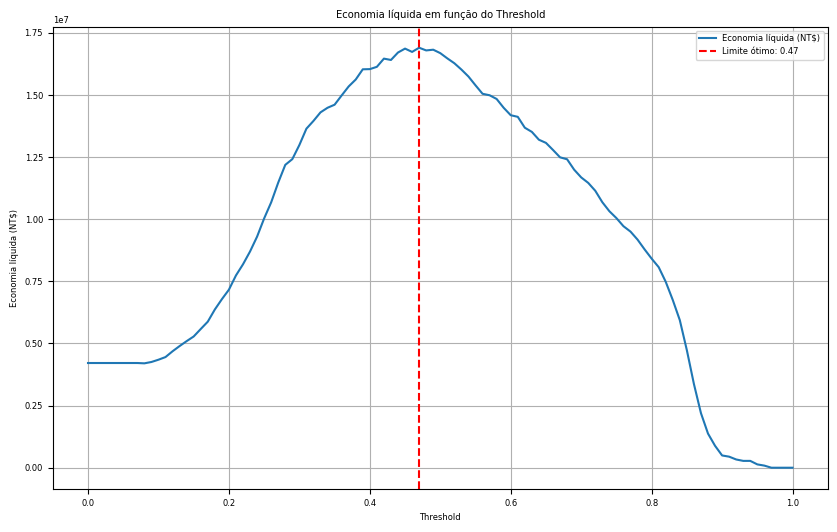

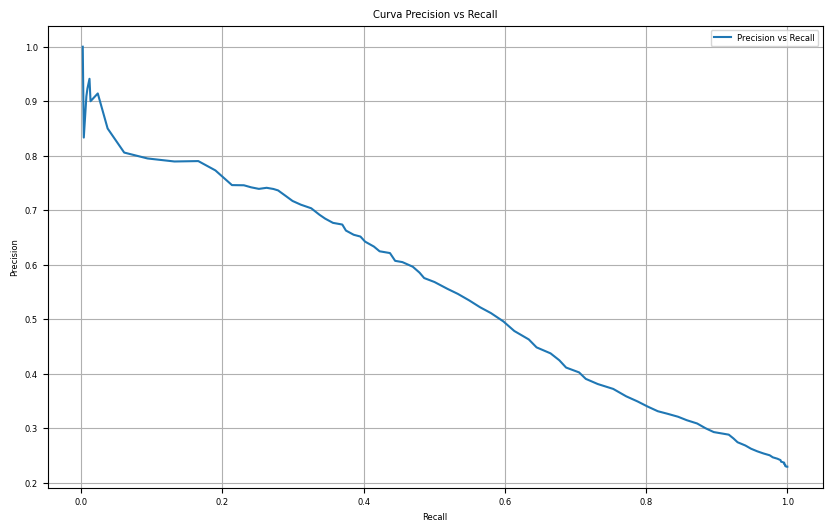

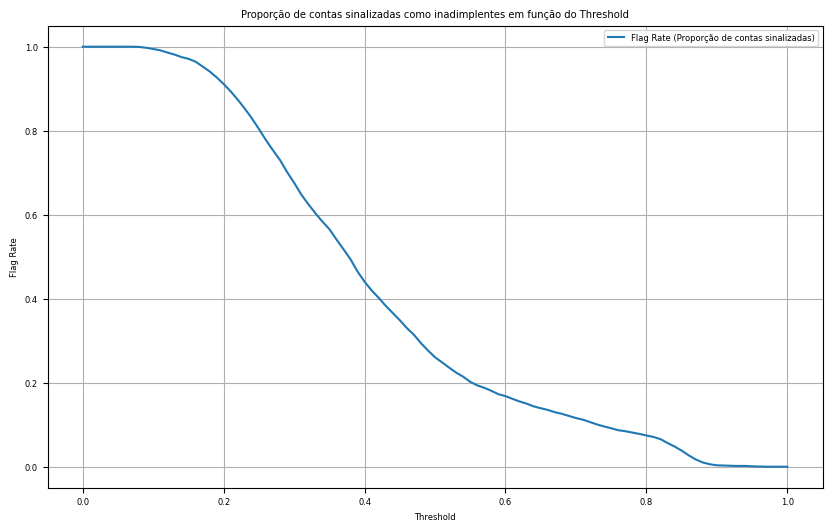

In [105]:
# ----- Análise Financeira -----

# Parâmetros fornecidos
cost_per_consulting = 7500  # Custo de cada sessão de aconselhamento
effectiveness = 0.70  # Taxa de sucesso do programa de aconselhamento

# Estimando o valor médio da fatura como a economia por inadimplência evitada
# savings_per_default = np.mean(X_test['bill_amt1'])
savings_per_default = np.mean(X_test[:, 6])

# Criando array de limites de probabilidade (thresholds)
thresholds = np.linspace(0, 1, 101)

# Arrays para armazenar resultados
n_pos_pred = np.zeros_like(thresholds)
cost_of_all_consultings = np.zeros_like(thresholds)
n_true_pos = np.zeros_like(thresholds)
savings_of_all_consultings = np.zeros_like(thresholds)
net_savings = np.zeros_like(thresholds)

# Loop pelos diferentes thresholds
for i, threshold in enumerate(thresholds):
    # Previsões positivas com base no threshold
    pos_pred = y_pred_proba > threshold
    n_pos_pred[i] = pos_pred.sum()  # Número de previsões positivas (clientes para aconselhamento)

    # Cálculo do custo de todas as sessões de aconselhamento
    cost_of_all_consultings[i] = n_pos_pred[i] * cost_per_consulting

    # Verdadeiros positivos: clientes que foram corretamente previstos como inadimplentes
    true_pos = pos_pred & (y_test == 1)
    n_true_pos[i] = true_pos.sum()  # Número de verdadeiros positivos

    # Economia com base nas contas previstas corretamente como inadimplentes
    savings_of_all_consultings[i] = n_true_pos[i] * savings_per_default * effectiveness

    # Economia líquida: economia obtida menos o custo do programa
    net_savings[i] = savings_of_all_consultings[i] - cost_of_all_consultings[i]

# Encontrar o índice com a maior economia líquida
max_savings_ix = np.argmax(net_savings)

# Exibir o threshold que resulta na maior economia líquida
optimal_threshold = thresholds[max_savings_ix]
print(f"O melhor threshold é {optimal_threshold:.2f}")

# Exibir o valor da maior economia líquida possível
max_net_savings = net_savings[max_savings_ix]
print(f"Maior economia líquida possível: NT$ {max_net_savings:.2f}")

# ----- Cálculos Complementares -----

# Custo total de todas as inadimplências no conjunto de teste
cost_of_defaults = y_test.sum() * savings_per_default
print(f"Custo total das inadimplências: NT$ {cost_of_defaults:.2f}")

# Percentual de diminuição da inadimplência com o programa
percentage_reduction = max_net_savings / cost_of_defaults * 100
print(f"Redução percentual da inadimplência: {percentage_reduction:.2f}%")

# Economia líquida por conta servida
net_savings_per_account = max_net_savings / len(y_test)
print(f"Economia líquida por conta: NT$ {net_savings_per_account:.2f}")

# ----- Gráficos -----

# Plot da economia líquida por threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, net_savings, label="Economia líquida (NT$)")
plt.axvline(optimal_threshold, color='r', linestyle='--', label=f"Limite ótimo: {optimal_threshold:.2f}")
plt.xlabel('Threshold')
plt.ylabel('Economia líquida (NT$)')
plt.title('Economia líquida em função do Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Gráfico de Precisão vs Recall
plt.figure(figsize=(10, 6))
precision = n_true_pos / n_pos_pred
recall = n_true_pos / sum(y_test)

plt.plot(recall, precision, label='Precision vs Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision vs Recall')
plt.legend()
plt.grid(True)
plt.show()

# Flag Rate: proporção de contas sinalizadas como inadimplentes por threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, n_pos_pred / len(y_test), label='Flag Rate (Proporção de contas sinalizadas)')
plt.xlabel('Threshold')
plt.ylabel('Flag Rate')
plt.title('Proporção de contas sinalizadas como inadimplentes em função do Threshold')
plt.legend()
plt.grid(True)
plt.show()

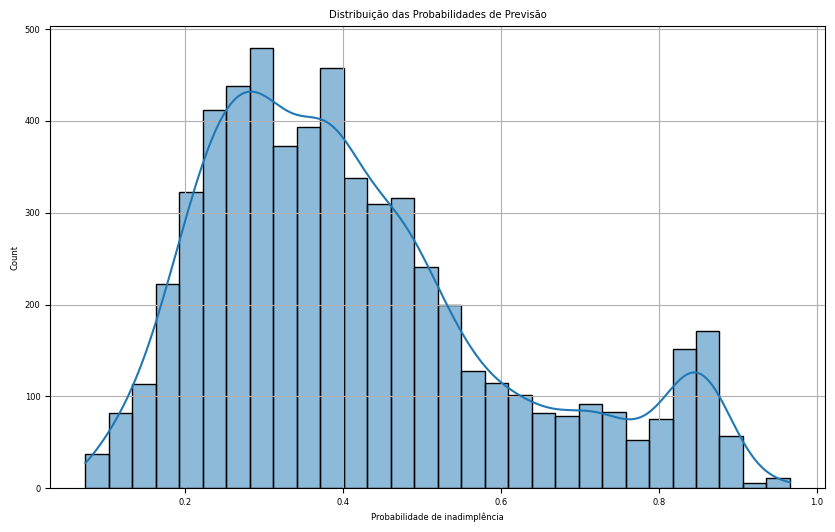

In [106]:
# Histograma das probabilidades de previsão
plt.figure(figsize=(10, 6))
sns.histplot(y_pred_proba, bins=30, kde=True)
plt.xlabel('Probabilidade de inadimplência')
plt.title('Distribuição das Probabilidades de Previsão')
plt.grid(True)
plt.show()

# Entrega Final da Lista de Prováveis Inadimplentes

In [107]:
df5[features_response[:-1]].columns

Index(['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_1',
       'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5',
       'bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5',
       'pay_amt6'],
      dtype='object')

In [108]:
# Converter X_test de volta para DataFrame
# As colunas devem corresponder às que você utilizou para treinar o modelo
X_test_df = pd.DataFrame(X_test, columns=['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_1',
       'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5',
       'bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5',
       'pay_amt6'])

# Adicionando as probabilidades de inadimplência ao conjunto de teste
X_test_df['probabilidade_inadimplencia'] = y_pred_proba

# Filtrando as contas com base no threshold ótimo
contas_inadimplentes = X_test_df[X_test_df['probabilidade_inadimplencia'] > optimal_threshold]

# Selecionando apenas os IDs das contas pelo index
ids_contas_inadimplentes = contas_inadimplentes.index

# Criando um DataFrame para exportação
df_contas_inadimplentes = pd.DataFrame({
    'ID_Conta': ids_contas_inadimplentes,
    'Probabilidade_Inadimplencia': contas_inadimplentes['probabilidade_inadimplencia']
})

# Ordenando o DataFrame pela probabilidade em ordem decrescente
df_contas_inadimplentes.sort_values(by='Probabilidade_Inadimplencia', ascending=False, inplace=True)

# Salvando em um arquivo CSV
df_contas_inadimplentes.to_csv('list_prob_default_accounts/contas_inadimplentes.csv', index=False)

print("Arquivo CSV criado com sucesso: contas_inadimplentes.csv")


Arquivo CSV criado com sucesso: contas_inadimplentes.csv


In [117]:
df_contas_inadimplentes.head(100)

,ID_Conta,Probabilidade_Inadimplencia
1481,1481,0.965598
428,428,0.965533
2742,2742,0.961696
150,150,0.955793
3268,3268,0.952736
...,...,...
3740,3740,0.870588
80,80,0.870486
4259,4259,0.870314
1563,1563,0.870289


# Monitoramento do Modelo
* Se a forma do histograma de probabilidades previstas mudar substancialmente, isso pode ser sinal de que o relacionamento entre as características e a resposta no conjunto de contas mudou e o modelo pode ter de ser retreinado ou reconstruído. Isso também pode ficar evidente se o número de contas previstas para inadimplir, de acordo com um limite selecionado, mudar de forma perceptível. 
* **Sempre verificar se a natureza das previsões está mudando com o tempo, em comparação com a população usada no treinamento do modelo.**

Text(0, 0.5, 'Number of accounts')

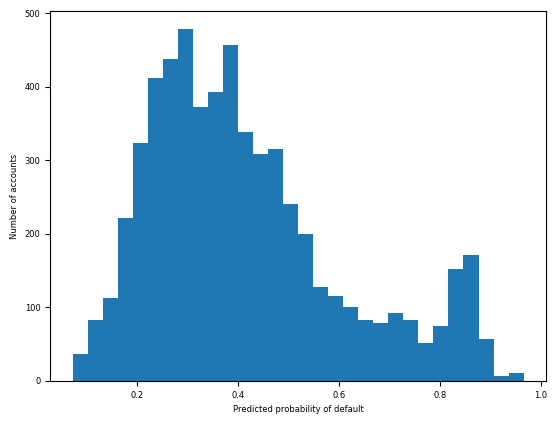

In [109]:
# monitorando a implementação do modelo
plt.hist(y_pred_proba[::], bins=30)
plt.xlabel('Predicted probability of default')
plt.ylabel('Number of accounts')